# Exploring feature selection strategies to monitor model performance

In this notebook we are going to try employing different feature selection strategies in an existing pipeline and try to understand its impact on performance of different models.

# Streamline model fit and validation

In order to compare the performance of different models, let's streamline the transformation, fit and prediction steps.

In [11]:
# Our training and validation features and target labels were prepared before:
import pickle
with open("X_val1.pkl","rb") as f:
    X_train = pickle.load(f)   
with open("y_val1.pkl","rb") as f:
    y_train = pickle.load(f)
        
with open("X_val2.pkl","rb") as f:
    X_val = pickle.load(f)       
with open("y_val2.pkl","rb") as f:
    y_val = pickle.load(f)    

In [114]:
# Write a function to streamline classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from datetime import datetime
import warnings
import pandas as pd
warnings.filterwarnings("ignore")


def calculate_validation(X_val_trans,y_val,clf):
    probs = clf.predict_proba(X_val_trans)[:,1]
    return roc_auc_score(y_val,probs)


def streamline_classifiers(fpipeline,nfeatures,X_train,y_train,X_val,y_val):
    """ We will monitor performance of different default classifiers."""
    print(">>> streamline_classifiers: started exploring model performance using " + str(nfeatures) + " features.")
    # Transform the training and test set using the current pipeline
    start = datetime.now()
    X_train_trans = fpipeline.fit(X_train,y_train).transform(X_train)
    process = datetime.now() - start
    print(" >>> streamline_classifiers: fitted and transformed X_train. It took: " + str(process.seconds/60) + " minutes.")
    print("Shape of X_train is " + str(X_train_trans.shape))
    start = datetime.now()
    X_val_trans = fpipeline.transform(X_val)
    process = datetime.now() - start
    print(" >>> streamline_classifiers: transformed X_val. It took: " + str(process.seconds/60) + " minutes.")
    print("Shape of X_val is " + str(X_val_trans.shape))
    #######################################################################
    # Train different classifiers report and calculate the validation score
    #######################################################################
    # LogisticRegression
    clf_dict = {
        "LogisticRegression": LogisticRegression(),
        "MultinomialNB":MultinomialNB(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "QuadraticDiscriminantAnalysis":QuadraticDiscriminantAnalysis()
    }
    
    # Container to collect current scores
    scores = pd.DataFrame()
    scores["nfeatures"] = pd.Series(nfeatures)
    
    for key,value in clf_dict.items():
        start = datetime.now()
        
        clf = value
        clf.fit(X_train_trans.toarray(),y_train)
        val_score =calculate_validation(X_val_trans.toarray(),y_val,clf)
        scores[key] = pd.Series(val_score)
        
        process = datetime.now() - start
        print(" >>> Completed " +str(key) + " classifier with an roc score of "+str(val_score) + " it took " +str(process.seconds/60)+ " minutes." )
        print("*" * 80)
    # Return a data frame of validation roc scores for a given number of features
    return scores



In [13]:
# Label text features
Text_features = ["app","device","os","channel"]

##############################################################
# Define utility function to parse and process text features
##############################################################
# Note we avoid lambda functions since they don't pickle when we want to save the pipeline later   
def column_text_processer_nolambda(df,text_columns = Text_features):
    import pandas as pd
    import numpy as np
    """"A function that will merge/join all text in a given row to make it ready for tokenization. 
    - This function should take care of converting missing values to empty strings. 
    - It should also convert the text to lowercase.
    df= pandas dataframe
    text_columns = names of the text features in df
    """ 
    # Select only non-text columns that are in the df
    text_data = df[text_columns]
    
    # Fill the missing values in text_data using empty strings
    text_data.fillna("",inplace=True)
    
    # Concatenate feature name to each category encoding for each row
    # E.g: encoding 3 at device column will read as device3 to make each encoding unique for a given feature
    for col_index in list(text_data.columns):
        text_data[col_index] = col_index + text_data[col_index].astype(str)
    
    # Join all the strings in a given row to make a vector
    # text_vector = text_data.apply(lambda x: " ".join(x), axis = 1)
    text_vector = []
    for index,rows in text_data.iterrows():
        text_item = " ".join(rows).lower()
        text_vector.append(text_item)

    # return text_vector as pd.Series object to enter the tokenization pipeline
    return pd.Series(text_vector)

#######################################################################
# Define custom processing functions to add the log_total_clicks and 
# log_total_click_time features, and remove the unwanted base features
#######################################################################
def column_time_processer(X_train):
    import pandas as pd
    import numpy as np

    # Convert click_time to datetime64 dtype 
    X_train.click_time = pd.to_datetime(X_train.click_time)

    # Calculate the log_total_clicks for each ip and add as a new feature to temp_data
    temp_data = pd.DataFrame(np.log(X_train.groupby(["ip"]).size()),
                                    columns = ["log_total_clicks"]).reset_index()


    # Calculate the log_total_click_time for each ip and add as a new feature to temp_data
    # First define a function to process selected ip group 
    def get_log_total_click_time(group):
        diff = (max(group.click_time) - min(group.click_time)).seconds
        return np.log(diff+1)

    # Then apply this function to each ip group and extract the total click time per ip group
    log_time_frame = pd.DataFrame(X_train.groupby(["ip"]).apply(get_log_total_click_time),
                                  columns=["log_total_click_time"]).reset_index()

    # Then add this new feature to the temp_data
    temp_data = pd.merge(temp_data,log_time_frame, how = "left",on = "ip")

    # Combine temp_data with X_train to maintain X_train key order
    temp_data = pd.merge(X_train,temp_data,how = "left",on = "ip")

    # Drop features that are not needed
    temp_data = temp_data[["log_total_clicks","log_total_click_time"]]

    # Return only the numeric features as a tensor to integrate into the numeric feature branch of the pipeline
    return temp_data


#############################################################################
# We need to wrap these custom utility functions using FunctionTransformer
from sklearn.preprocessing import FunctionTransformer
# FunctionTransformer wrapper of utility functions to parse text and numeric features
# Note how we avoid putting any arguments into column_text_processer or column_time_processer
#############################################################################
get_numeric_data = FunctionTransformer(func = column_time_processer, validate=False) 
get_text_data = FunctionTransformer(func = column_text_processer_nolambda,validate=False) 

#############################################################################
# Create the token pattern: TOKENS_ALPHANUMERIC
# #Note this regex will match either a whitespace or a punctuation to tokenize 
# the string vector on these preferences, in our case we only have white spaces in our text  
#############################################################################
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'  

In [46]:
######################################################
# Construct our feature extraction selection pipeline
######################################################
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import MaxAbsScaler, Imputer
from sklearn.feature_selection import SelectKBest,VarianceThreshold, chi2,SelectFromModel
from SparseInteractions import * #Load SparseInteractions (from : https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/features/SparseInteractions.py) as a module
from sklearn.svm import LinearSVC

nfeatures = "SelectFromSVC"

featureselection_pipeline = Pipeline([
        ("union",FeatureUnion(
            # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
            # is the name of the transformer within the FeatureUnion

            transformer_list = [

                ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                    ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                    ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                ])), # End of: numeric_subpipeline

                ("text_subpipeline",Pipeline([
                    ("parser",get_text_data), # Step1: parse the text data 
                    ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                 ngram_range = (1,1),
                                                 non_negative=True, 
                                                 norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                    ('dim_red', SelectKBest(k=nfeatures) # Step3: use dimension reduction to select best features 
                ]))
            ]

        )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

        # Common steps:

        ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms up to the second degree polynomial
        ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
        ('dim_red2', SelectKBest(k=100))
    ])# End of: featureselection_pipeline

result = streamline_classifiers(fpipeline=featureselection_pipeline,
                       nfeatures = nfeatures,X_train = X_train,y_train = y_train,
                       X_val = X_val,y_val = y_val)

>>> streamline_classifiers: started exploring model performance using SelectFromSVC features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 13.366666666666667 minutes.
Shape of X_train is (1000000, 2464)
 >>> streamline_classifiers: transformed X_val. It took: 3.566666666666667 minutes.
Shape of X_val is (1000000, 2464)
 >>> Completed LogisticRegression classifier with an roc score of 0.951678536123 it took 0.18333333333333332 minutes.
********************
 >>> Completed MultinomialNB classifier with an roc score of 0.942329960157 it took 0.0 minutes.
********************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.931726238424 it took 4.383333333333334 minutes.
********************


In [56]:
result.columns.values.tolist()

['nfeatures', 'LogisticRegression', 'MultinomialNB', 'AdaBoostClassifier']

In [57]:
results = pd.DataFrame(columns=['nfeatures', 'LogisticRegression', 'MultinomialNB', 'AdaBoostClassifier'])

In [58]:
results

,nfeatures,LogisticRegression,MultinomialNB,AdaBoostClassifier


In [ ]:
######################################################
# Construct our feature extraction selection pipeline
######################################################
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest,VarianceThreshold, chi2,SelectFromModel
from SparseInteractions import * #Load SparseInteractions (from : https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/features/SparseInteractions.py) as a module
from sklearn.svm import LinearSVC

nfeatures_list = [10,20,30,50]
results = pd.DataFrame(columns=['nfeatures', 'LogisticRegression', 'MultinomialNB', 'AdaBoostClassifier'])

for nfeatures in nfeatures_list:
  
    featureselection_pipeline = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=nfeatures)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=3)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100))
        ])# End of: featureselection_pipeline

    results = pd.concat([results, streamline_classifiers(fpipeline=featureselection_pipeline,
                       nfeatures = nfeatures,X_train = X_train,y_train = y_train,
                       X_val = X_val,y_val = y_val)], axis = 0)
    print("--" * 40)

In [68]:
results

,nfeatures,LogisticRegression,MultinomialNB,AdaBoostClassifier
0,10,0.888943,0.887109,0.872207
0,20,0.893488,0.883378,0.893272
0,30,0.893283,0.883365,0.889234
0,50,0.893283,0.883365,0.889234


In [70]:
######################################################
# Construct our feature extraction selection pipeline
######################################################
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import MaxAbsScaler, Imputer
from sklearn.feature_selection import SelectKBest,VarianceThreshold, chi2,SelectFromModel
from SparseInteractions import * #Load SparseInteractions (from : https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/features/SparseInteractions.py) as a module
from sklearn.svm import LinearSVC

nfeatures_list = [10,20,50,100,200,500,1000,2000,5000]
results = pd.DataFrame(columns=['nfeatures', 'LogisticRegression', 'MultinomialNB', 'AdaBoostClassifier'])

for nfeatures in nfeatures_list:
  
    featureselection_pipeline = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = nfeatures))
        ])# End of: featureselection_pipeline

    results = pd.concat([results, streamline_classifiers(fpipeline=featureselection_pipeline,
                       nfeatures = nfeatures,X_train = X_train,y_train = y_train,
                       X_val = X_val,y_val = y_val)], axis = 0)
    print("--" * 50)

>>> streamline_classifiers: started exploring model performance using 10 features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 7.733333333333333 minutes.
Shape of X_train is (1000000, 10)
 >>> streamline_classifiers: transformed X_val. It took: 3.783333333333333 minutes.
Shape of X_val is (1000000, 10)
 >>> Completed LogisticRegression classifier with an roc score of 0.741096318523 it took 0.03333333333333333 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.477099483832 it took 0.0 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.741077284969 it took 0.3333333333333333 minutes.
********************************************************************************
-----------------------------------------------------------------------------------------------

 >>> Completed LogisticRegression classifier with an roc score of 0.951570299903 it took 0.18333333333333332 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.942506764896 it took 0.0 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.931726238424 it took 4.866666666666666 minutes.
********************************************************************************
----------------------------------------------------------------------------------------------------


In [71]:
results

,nfeatures,LogisticRegression,MultinomialNB,AdaBoostClassifier
0,10,0.741096,0.477099,0.741077
0,20,0.870281,0.869970,0.868690
0,50,0.885522,0.880458,0.882335
0,100,0.892628,0.884411,0.889322
0,200,0.899964,0.891626,0.900375
0,500,0.904338,0.894316,0.888938
0,1000,0.942774,0.922506,0.913993
0,2000,0.951608,0.943533,0.931726
0,5000,0.951570,0.942507,0.931726


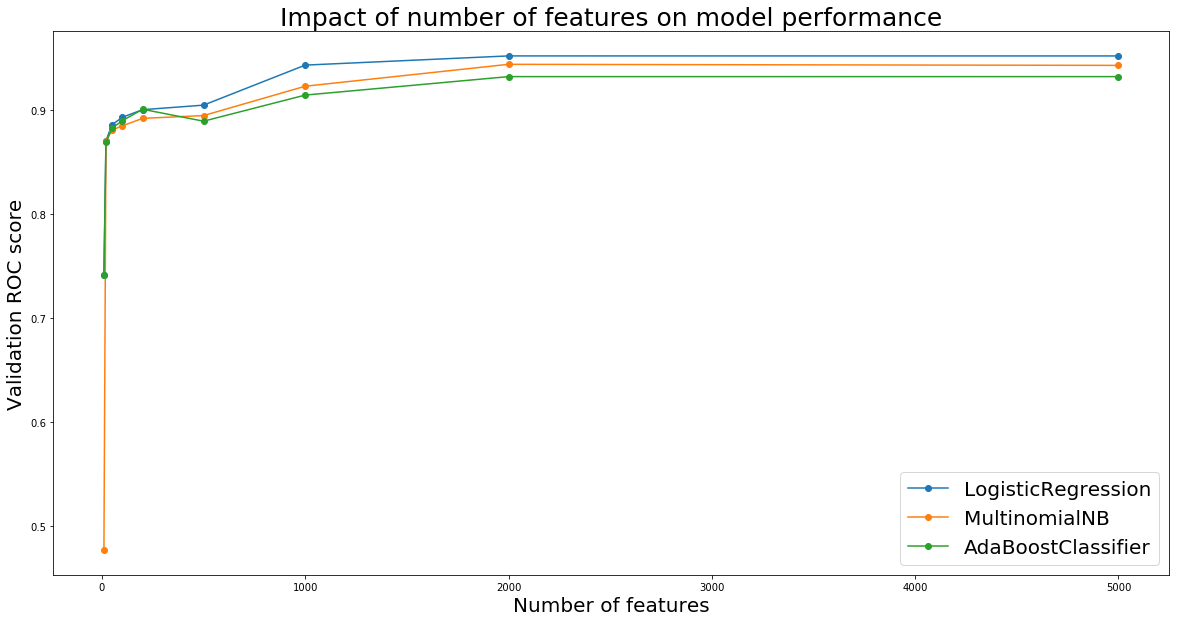

In [98]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot('nfeatures','LogisticRegression', data=results, label = "LogisticRegression", marker = 'o')
plt.plot('nfeatures','MultinomialNB', data=results, label = "MultinomialNB", marker = 'o')
plt.plot('nfeatures','AdaBoostClassifier', data=results, label = "AdaBoostClassifier", marker = 'o')
plt.xlabel("Number of features",fontsize=20)
plt.ylabel("Validation ROC score",fontsize=20)
plt.title("Impact of number of features on model performance",fontsize=25)
plt.legend(fontsize=20)
plt.show()


It looks like adding more features beyond 2000 features have minimum impact on model performance. For this data set, it is seems to keep only the 100 best features before hyperparameter optimization.

Let's see what we can do by using class-balanced training set we prepared earlier, and just keep 100 features:

In [100]:
import pickle
from sklearn.metrics import roc_auc_score

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced.pkl","rb") as f:
    X_train_balanced = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f) 
nfeatures = 100
featureselection_pipeline = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100))
        ])# End of: featureselection_pipeline

results_balanced = streamline_classifiers(fpipeline=featureselection_pipeline,
                       nfeatures = nfeatures,X_train = X_train_balanced,y_train = y_train_balanced,
                       X_val = X_val,y_val = y_val)

>>> streamline_classifiers: started exploring model performance using 100 features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 8.666666666666666 minutes.
Shape of X_train is (835222, 100)
 >>> streamline_classifiers: transformed X_val. It took: 4.283333333333333 minutes.
Shape of X_val is (1000000, 100)
 >>> Completed LogisticRegression classifier with an roc score of 0.930089232869 it took 0.21666666666666667 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.909096172642 it took 0.0 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.905051130916 it took 2.566666666666667 minutes.
********************************************************************************


It looks like having 100 features extracted from a class-balanced training set increases the model performance. This is a good point to start hyperparameter tuning. 

As another last step, let's also look at the impact of changing standardization approach to standardscaler.

In [105]:
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced.pkl","rb") as f:
    X_train_balanced = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f) 
nfeatures = 100
featureselection_pipeline = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",StandardScaler(with_mean = False)), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100))
        ])# End of: featureselection_pipeline

results_balanced = streamline_classifiers(fpipeline=featureselection_pipeline,
                       nfeatures = nfeatures,X_train = X_train_balanced,y_train = y_train_balanced,
                       X_val = X_val,y_val = y_val)

>>> streamline_classifiers: started exploring model performance using 100 features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 8.866666666666667 minutes.
Shape of X_train is (835222, 100)
 >>> streamline_classifiers: transformed X_val. It took: 4.6 minutes.
Shape of X_val is (1000000, 100)
 >>> Completed LogisticRegression classifier with an roc score of 0.930163951143 it took 0.31666666666666665 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.908413806202 it took 0.0 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.905051130916 it took 2.5166666666666666 minutes.
********************************************************************************


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

Changing scaler has almost no impact. How about adding an additional layer of interaction terms?

In [110]:
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced.pkl","rb") as f:
    X_train_balanced = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f) 
nfeatures = 100
featureselection_pipeline2 = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100)),
            ("int2", SparseInteractions(degree=2)), # Add another layer of interaction terms
            ("scaler2",MaxAbsScaler()), # Scale the features between 0 and 1. 
            ('dim_red3', SelectKBest(k = 100)) # Final dim reduction
    
        ])# End of: featureselection_pipeline

results_balanced2 = streamline_classifiers(fpipeline=featureselection_pipeline2,
                       nfeatures = nfeatures,X_train = X_train_balanced,y_train = y_train_balanced,
                       X_val = X_val,y_val = y_val)

>>> streamline_classifiers: started exploring model performance using 100 features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 8.95 minutes.
Shape of X_train is (835222, 100)
 >>> streamline_classifiers: transformed X_val. It took: 4.483333333333333 minutes.
Shape of X_val is (1000000, 100)
 >>> Completed LogisticRegression classifier with an roc score of 0.863151700077 it took 0.38333333333333336 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.865338183448 it took 0.0 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.857186962408 it took 5.583333333333333 minutes.
********************************************************************************


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

This 'interactions of interactions' step actually makes things worse! 

In [111]:
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced.pkl","rb") as f:
    X_train_balanced = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f) 
nfeatures = 100
featureselection_pipeline2 = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=-1)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100))
            
        ])# End of: featureselection_pipeline

results_balanced2 = streamline_classifiers(fpipeline=featureselection_pipeline2,
                       nfeatures = nfeatures,X_train = X_train_balanced,y_train = y_train_balanced,
                       X_val = X_val,y_val = y_val)

>>> streamline_classifiers: started exploring model performance using 100 features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 4.033333333333333 minutes.
Shape of X_train is (835222, 100)
 >>> streamline_classifiers: transformed X_val. It took: 1.8 minutes.
Shape of X_val is (1000000, 100)
 >>> Completed LogisticRegression classifier with an roc score of 0.94183735489 it took 0.08333333333333333 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.921752481276 it took 0.0 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.923818389827 it took 1.0166666666666666 minutes.
********************************************************************************


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

Adding -1 degree of interaction terms increased model performance. How about we further reduce this number?

In [113]:
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced.pkl","rb") as f:
    X_train_balanced = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f) 
nfeatures = 100
featureselection_pipeline2 = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=-2)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100))
            
        ])# End of: featureselection_pipeline

results_balanced3 = streamline_classifiers(fpipeline=featureselection_pipeline2,
                       nfeatures = nfeatures,X_train = X_train_balanced,y_train = y_train_balanced,
                       X_val = X_val,y_val = y_val)

>>> streamline_classifiers: started exploring model performance using 100 features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 4.633333333333334 minutes.
Shape of X_train is (835222, 100)
 >>> streamline_classifiers: transformed X_val. It took: 1.8166666666666667 minutes.
Shape of X_val is (1000000, 100)
 >>> Completed LogisticRegression classifier with an roc score of 0.94183632925 it took 0.1 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.921752481276 it took 0.016666666666666666 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.923818389827 it took 3.466666666666667 minutes.
********************************************************************************


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [116]:
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced.pkl","rb") as f:
    X_train_balanced = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f) 
nfeatures = 100
featureselection_pipeline2 = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=-3)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100))
            
        ])# End of: featureselection_pipeline

results_balanced3 = streamline_classifiers(fpipeline=featureselection_pipeline2,
                       nfeatures = nfeatures,X_train = X_train_balanced,y_train = y_train_balanced,
                       X_val = X_val,y_val = y_val)

>>> streamline_classifiers: started exploring model performance using 100 features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 4.0 minutes.
Shape of X_train is (835222, 100)
 >>> streamline_classifiers: transformed X_val. It took: 1.7833333333333334 minutes.
Shape of X_val is (1000000, 100)
 >>> Completed LogisticRegression classifier with an roc score of 0.94183632925 it took 0.1 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.921752481276 it took 0.03333333333333333 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.923818389827 it took 3.566666666666667 minutes.
********************************************************************************
 >>> Completed QuadraticDiscriminantAnalysis classifier with an roc score of 0.904390002748 it took 0.416666

It looks like choosing -1 degree of interactions for features give better model performance. Let's transform class-balanced training set and validation sets using this simplified pipeline. 

In [117]:
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MaxAbsScaler

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced.pkl","rb") as f:
    X_train_balanced = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f)
    
# Our validation features and target labels were prepared before:
import pickle
with open("X_val1.pkl","rb") as f:
    X_val1 = pickle.load(f)   
with open("y_val1.pkl","rb") as f:
    y_val1 = pickle.load(f)
        
with open("X_val2.pkl","rb") as f:
    X_val2 = pickle.load(f)       
with open("y_val2.pkl","rb") as f:
    y_val2 = pickle.load(f)      

featureselection_pipeline = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree= -1)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100))
        ])# End of: featureselection_pipeline

print("Started training pipeline.")
# Fit the pipeline using the training set
featureselection_pipeline.fit(X_train_balanced,y_train_balanced)
print("Trained pipeline.")

# Save the trained pipeline as 'featureselection_pipeline100.pkl'
with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/featureselection_pipeline100.pkl","wb") as f:
    pickle.dump(featureselection_pipeline,f)
print("Saved pipeline.")

# Transform training set
X_train_balanced_trans_100 = featureselection_pipeline.transform(X_train_balanced)
with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced_trans_100.pkl","wb") as f:
    pickle.dump(X_train_balanced_trans_100,f)
print("Saved X_train_balanced_trans_100." + str(X_train_balanced_trans_100.shape))

# Transform X_val1 set
X_val1_trans_100 = featureselection_pipeline.transform(X_val1)
with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_val1_trans_100.pkl","wb") as f:
    pickle.dump(X_val1_trans_100,f)
print("Saved X_val1_trans_100." + str(X_val1_trans_100.shape))

# Transform X_val2 set
X_val2_trans_100 = featureselection_pipeline.transform(X_val2)
with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_val2_trans_100.pkl","wb") as f:
    pickle.dump(X_val2_trans_100,f)
print("Saved X_val2_trans_100." + str(X_val2_trans_100.shape))

Started training pipeline.
Trained pipeline.
Saved pipeline.
Saved X_train_balanced_trans_100.(835222, 100)
Saved X_val1_trans_100.(1000000, 100)
Saved X_val2_trans_100.(1000000, 100)


# Training Neural Network Using the New Feature Set

In [118]:
# Loading class-balanced and pipeline 2 processed training set
import pickle
with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced_trans_100.pkl","rb") as f:
    X_train_balanced_trans_100 = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f) 
    

In [120]:
from keras import models, metrics, layers
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(32,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=20,batch_size=500,validation_split= 0.5)

Train on 417611 samples, validate on 417611 samples
Epoch 1/20
417611/417611 [==============================] - 6s 14us/step - loss: 0.2536 - acc: 0.9017 - val_loss: 0.2184 - val_acc: 0.9166
Epoch 2/20
417611/417611 [==============================] - 5s 12us/step - loss: 0.2214 - acc: 0.9134 - val_loss: 0.2149 - val_acc: 0.9184
Epoch 3/20
417611/417611 [==============================] - 6s 13us/step - loss: 0.2194 - acc: 0.9138 - val_loss: 0.2136 - val_acc: 0.9189
Epoch 4/20
417611/417611 [==============================] - 6s 14us/step - loss: 0.2181 - acc: 0.9144 - val_loss: 0.2134 - val_acc: 0.9192
Epoch 5/20
417611/417611 [==============================] - 5s 12us/step - loss: 0.2173 - acc: 0.9146 - val_loss: 0.2128 - val_acc: 0.9190
Epoch 6/20
417611/417611 [==============================] - 5s 12us/step - loss: 0.2164 - acc: 0.9148 - val_loss: 0.2122 - val_acc: 0.9202
Epoch 7/20
417611/417611 [==============================] - 6s 14us/step - loss: 0.2158 - acc: 0.9150 - val_loss: 

In [142]:
from keras import models, metrics, layers
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=40,batch_size=200,validation_split= 0.5)

Train on 417611 samples, validate on 417611 samples
Epoch 1/40
417611/417611 [==============================] - 12s 28us/step - loss: 0.2455 - acc: 0.9005 - val_loss: 0.2160 - val_acc: 0.9177
Epoch 2/40
417611/417611 [==============================] - 10s 25us/step - loss: 0.2204 - acc: 0.9133 - val_loss: 0.2152 - val_acc: 0.9183
Epoch 3/40
417611/417611 [==============================] - 10s 25us/step - loss: 0.2187 - acc: 0.9140 - val_loss: 0.2150 - val_acc: 0.9185
Epoch 4/40
417611/417611 [==============================] - 11s 26us/step - loss: 0.2175 - acc: 0.9147 - val_loss: 0.2153 - val_acc: 0.9184
Epoch 5/40
417611/417611 [==============================] - 11s 25us/step - loss: 0.2170 - acc: 0.9148 - val_loss: 0.2135 - val_acc: 0.9188
Epoch 6/40
417611/417611 [==============================] - 10s 25us/step - loss: 0.2163 - acc: 0.9149 - val_loss: 0.2148 - val_acc: 0.9183
Epoch 7/40
417611/417611 [==============================] - 10s 25us/step - loss: 0.2158 - acc: 0.9152 - val

Min loss: 0.211369023644 at epoch 40
Min val loss: 0.21146884427 at epoch 35


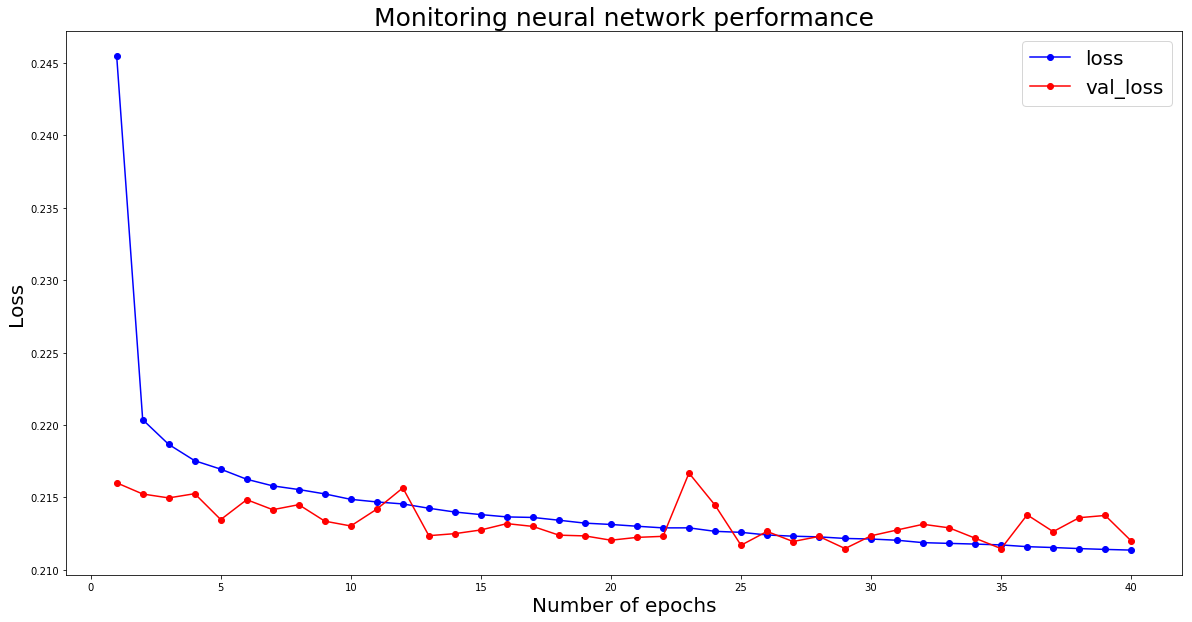

In [173]:
import matplotlib.pyplot as plt
epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()


Train on 417611 samples, validate on 417611 samples
Epoch 1/40
417611/417611 [==============================] - 10s 24us/step - loss: 0.2112 - acc: 0.9165 - val_loss: 0.2123 - val_acc: 0.9180
Epoch 2/40
417611/417611 [==============================] - 11s 25us/step - loss: 0.2112 - acc: 0.9163 - val_loss: 0.2127 - val_acc: 0.9179
Epoch 3/40
417611/417611 [==============================] - 10s 25us/step - loss: 0.2111 - acc: 0.9163 - val_loss: 0.2182 - val_acc: 0.9162
Epoch 4/40
417611/417611 [==============================] - 11s 25us/step - loss: 0.2110 - acc: 0.9165 - val_loss: 0.2125 - val_acc: 0.9183
Epoch 5/40
417611/417611 [==============================] - 10s 25us/step - loss: 0.2110 - acc: 0.9164 - val_loss: 0.2131 - val_acc: 0.9179
Epoch 6/40
417611/417611 [==============================] - 11s 26us/step - loss: 0.2110 - acc: 0.9166 - val_loss: 0.2130 - val_acc: 0.9182
Epoch 7/40
417611/417611 [==============================] - 11s 26us/step - loss: 0.2109 - acc: 0.9162 - val

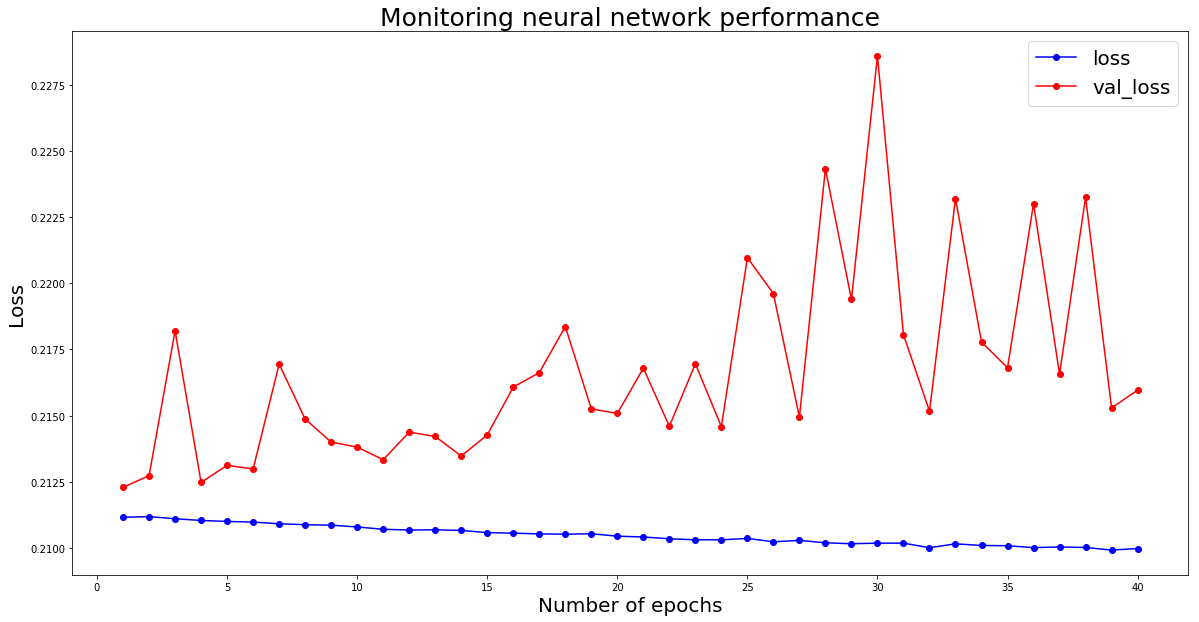

In [175]:
# Training the same network for another 40 epochs
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=40,batch_size=200,validation_split= 0.5)
import matplotlib.pyplot as plt
epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 15s 35us/step - loss: 0.2360 - acc: 0.9078 - val_loss: 0.2143 - val_acc: 0.9196
Epoch 2/100
417611/417611 [==============================] - 13s 31us/step - loss: 0.2190 - acc: 0.9141 - val_loss: 0.2124 - val_acc: 0.9202
Epoch 3/100
417611/417611 [==============================] - 14s 35us/step - loss: 0.2171 - acc: 0.9149 - val_loss: 0.2121 - val_acc: 0.9195
Epoch 4/100
417611/417611 [==============================] - 14s 32us/step - loss: 0.2160 - acc: 0.9153 - val_loss: 0.2125 - val_acc: 0.9200
Epoch 5/100
417611/417611 [==============================] - 12s 28us/step - loss: 0.2153 - acc: 0.9155 - val_loss: 0.2125 - val_acc: 0.9196
Epoch 6/100
417611/417611 [==============================] - 14s 34us/step - loss: 0.2148 - acc: 0.9156 - val_loss: 0.2140 - val_acc: 0.9195
Epoch 7/100
417611/417611 [==============================] - 12s 29us/step - loss: 0.2145 - acc: 0.915

417611/417611 [==============================] - 10s 25us/step - loss: 0.2083 - acc: 0.9173 - val_loss: 0.2382 - val_acc: 0.9131
Epoch 59/100
417611/417611 [==============================] - 11s 26us/step - loss: 0.2082 - acc: 0.9172 - val_loss: 0.2317 - val_acc: 0.9175
Epoch 60/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2082 - acc: 0.9172 - val_loss: 0.2400 - val_acc: 0.9102
Epoch 61/100
417611/417611 [==============================] - 10s 25us/step - loss: 0.2082 - acc: 0.9173 - val_loss: 0.2330 - val_acc: 0.9159
Epoch 62/100
417611/417611 [==============================] - 10s 24us/step - loss: 0.2081 - acc: 0.9173 - val_loss: 0.2410 - val_acc: 0.9104
Epoch 63/100
417611/417611 [==============================] - 11s 25us/step - loss: 0.2081 - acc: 0.9173 - val_loss: 0.2395 - val_acc: 0.9126
Epoch 64/100
417611/417611 [==============================] - 10s 24us/step - loss: 0.2081 - acc: 0.9173 - val_loss: 0.2348 - val_acc: 0.9146
Epoch 65/100
417611

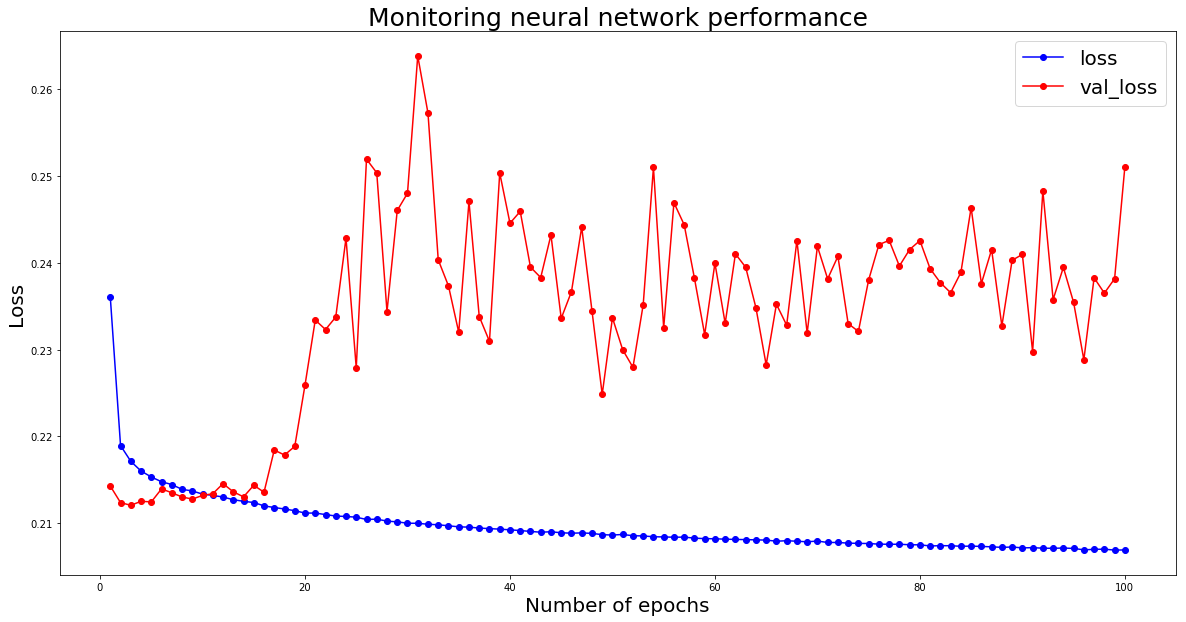

In [176]:
# It started over fitting after 35 epochs, let's slighly increase model complexity to monitor performance
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(32,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

This network starts overfitting earlier and does not perform as good as the earlier model. Let's go back to earlier network and slightly decrease model complexity.

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2503 - acc: 0.9014 - val_loss: 0.2185 - val_acc: 0.9173
Epoch 2/100
417611/417611 [==============================] - 15s 36us/step - loss: 0.2221 - acc: 0.9128 - val_loss: 0.2148 - val_acc: 0.9190
Epoch 3/100
417611/417611 [==============================] - 11s 25us/step - loss: 0.2211 - acc: 0.9133 - val_loss: 0.2137 - val_acc: 0.9192
Epoch 4/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2203 - acc: 0.9135 - val_loss: 0.2168 - val_acc: 0.9175
Epoch 5/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2194 - acc: 0.9139 - val_loss: 0.2138 - val_acc: 0.9196
Epoch 6/100
417611/417611 [==============================] - 11s 26us/step - loss: 0.2188 - acc: 0.9141 - val_loss: 0.2145 - val_acc: 0.9191
Epoch 7/100
417611/417611 [==============================] - 10s 24us/step - loss: 0.2182 - acc: 0.914

417611/417611 [==============================] - 11s 26us/step - loss: 0.2139 - acc: 0.9159 - val_loss: 0.2148 - val_acc: 0.9178
Epoch 59/100
417611/417611 [==============================] - 10s 24us/step - loss: 0.2139 - acc: 0.9158 - val_loss: 0.2171 - val_acc: 0.9176
Epoch 60/100
417611/417611 [==============================] - 10s 24us/step - loss: 0.2138 - acc: 0.9160 - val_loss: 0.2144 - val_acc: 0.9187
Epoch 61/100
417611/417611 [==============================] - 10s 24us/step - loss: 0.2138 - acc: 0.9159 - val_loss: 0.2135 - val_acc: 0.9192
Epoch 62/100
417611/417611 [==============================] - 10s 25us/step - loss: 0.2138 - acc: 0.9160 - val_loss: 0.2135 - val_acc: 0.9189
Epoch 63/100
417611/417611 [==============================] - 10s 24us/step - loss: 0.2137 - acc: 0.9160 - val_loss: 0.2153 - val_acc: 0.9191
Epoch 64/100
417611/417611 [==============================] - 10s 24us/step - loss: 0.2138 - acc: 0.9159 - val_loss: 0.2150 - val_acc: 0.9188
Epoch 65/100
417611

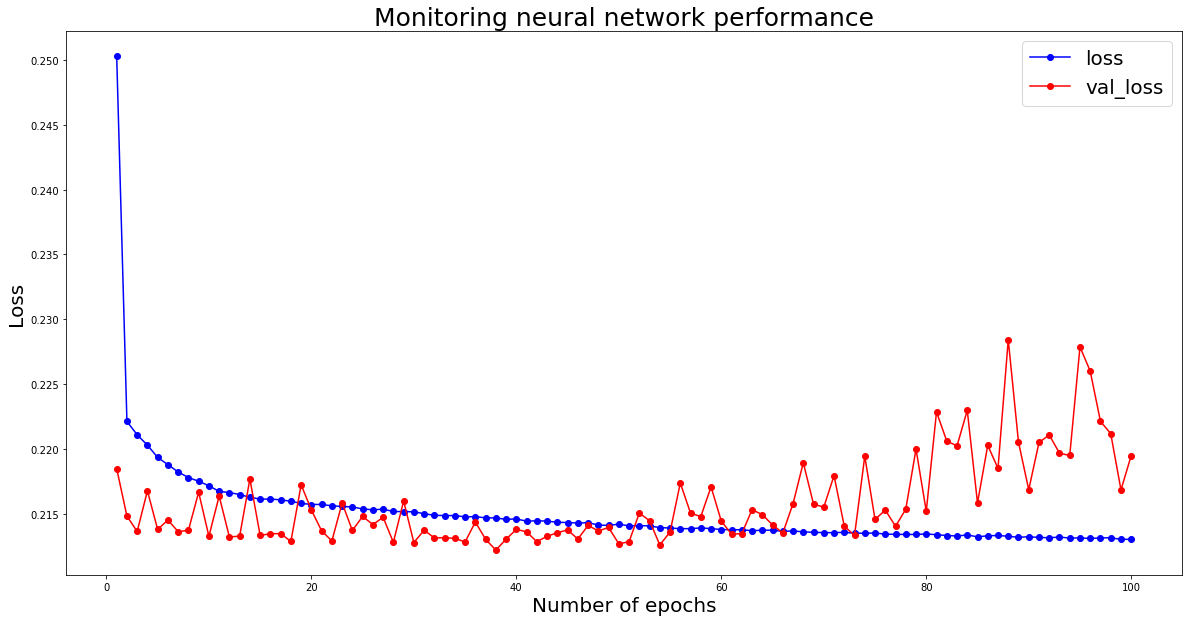

In [177]:
# It started over fitting after 35 epochs, let's slighly increase model complexity to monitor performance
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(8,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 12s 29us/step - loss: 0.2500 - acc: 0.9009 - val_loss: 0.2192 - val_acc: 0.9172
Epoch 2/100
417611/417611 [==============================] - 11s 26us/step - loss: 0.2225 - acc: 0.9126 - val_loss: 0.2162 - val_acc: 0.9181
Epoch 3/100
417611/417611 [==============================] - 10s 25us/step - loss: 0.2207 - acc: 0.9135 - val_loss: 0.2145 - val_acc: 0.9185
Epoch 4/100
417611/417611 [==============================] - 10s 24us/step - loss: 0.2196 - acc: 0.9139 - val_loss: 0.2141 - val_acc: 0.9187
Epoch 5/100
417611/417611 [==============================] - 12s 29us/step - loss: 0.2188 - acc: 0.9143 - val_loss: 0.2155 - val_acc: 0.9170
Epoch 6/100
417611/417611 [==============================] - 11s 25us/step - loss: 0.2180 - acc: 0.9144 - val_loss: 0.2139 - val_acc: 0.9186
Epoch 7/100
417611/417611 [==============================] - 11s 26us/step - loss: 0.2174 - acc: 0.914

417611/417611 [==============================] - 10s 24us/step - loss: 0.2112 - acc: 0.9165 - val_loss: 0.2122 - val_acc: 0.9191
Epoch 59/100
417611/417611 [==============================] - 11s 25us/step - loss: 0.2112 - acc: 0.9165 - val_loss: 0.2120 - val_acc: 0.9192
Epoch 60/100
417611/417611 [==============================] - 11s 26us/step - loss: 0.2112 - acc: 0.9164 - val_loss: 0.2117 - val_acc: 0.9187
Epoch 61/100
417611/417611 [==============================] - 10s 24us/step - loss: 0.2111 - acc: 0.9165 - val_loss: 0.2124 - val_acc: 0.9179
Epoch 62/100
417611/417611 [==============================] - 11s 25us/step - loss: 0.2111 - acc: 0.9166 - val_loss: 0.2141 - val_acc: 0.9174
Epoch 63/100
417611/417611 [==============================] - 11s 25us/step - loss: 0.2111 - acc: 0.9165 - val_loss: 0.2115 - val_acc: 0.9192
Epoch 64/100
417611/417611 [==============================] - 11s 26us/step - loss: 0.2111 - acc: 0.9164 - val_loss: 0.2125 - val_acc: 0.9177
Epoch 65/100
417611

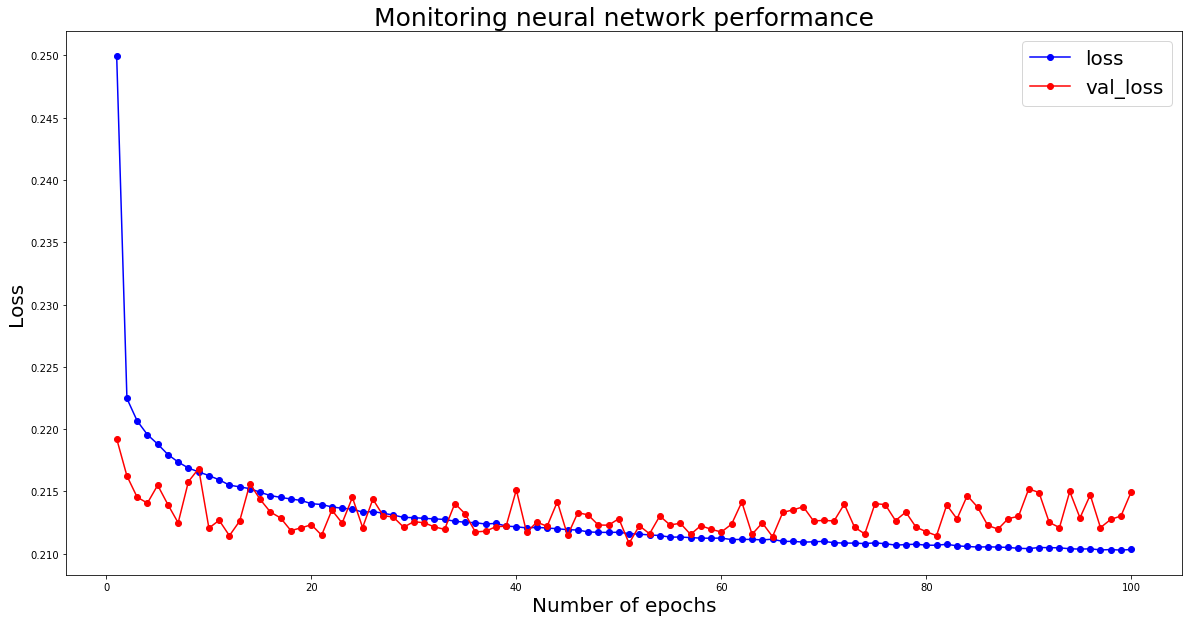

In [178]:
# Let's increase a bit
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 14s 34us/step - loss: 0.2450 - acc: 0.9019 - val_loss: 0.2170 - val_acc: 0.9179
Epoch 2/100
417611/417611 [==============================] - 12s 28us/step - loss: 0.2219 - acc: 0.9125 - val_loss: 0.2134 - val_acc: 0.9199
Epoch 3/100
417611/417611 [==============================] - 12s 28us/step - loss: 0.2199 - acc: 0.9135 - val_loss: 0.2133 - val_acc: 0.9193
Epoch 4/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2185 - acc: 0.9141 - val_loss: 0.2125 - val_acc: 0.9199
Epoch 5/100
417611/417611 [==============================] - 12s 29us/step - loss: 0.2176 - acc: 0.9147 - val_loss: 0.2133 - val_acc: 0.9192
Epoch 6/100
417611/417611 [==============================] - 12s 29us/step - loss: 0.2170 - acc: 0.9148 - val_loss: 0.2172 - val_acc: 0.9158
Epoch 7/100
417611/417611 [==============================] - 12s 29us/step - loss: 0.2165 - acc: 0.914

417611/417611 [==============================] - 11s 27us/step - loss: 0.2111 - acc: 0.9165 - val_loss: 0.2118 - val_acc: 0.9190
Epoch 59/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2110 - acc: 0.9169 - val_loss: 0.2111 - val_acc: 0.9200
Epoch 60/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2110 - acc: 0.9167 - val_loss: 0.2114 - val_acc: 0.9198
Epoch 61/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2109 - acc: 0.9168 - val_loss: 0.2117 - val_acc: 0.9190
Epoch 62/100
417611/417611 [==============================] - 12s 28us/step - loss: 0.2108 - acc: 0.9168 - val_loss: 0.2130 - val_acc: 0.9183
Epoch 63/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2109 - acc: 0.9168 - val_loss: 0.2118 - val_acc: 0.9196
Epoch 64/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2108 - acc: 0.9167 - val_loss: 0.2121 - val_acc: 0.9189
Epoch 65/100
417611

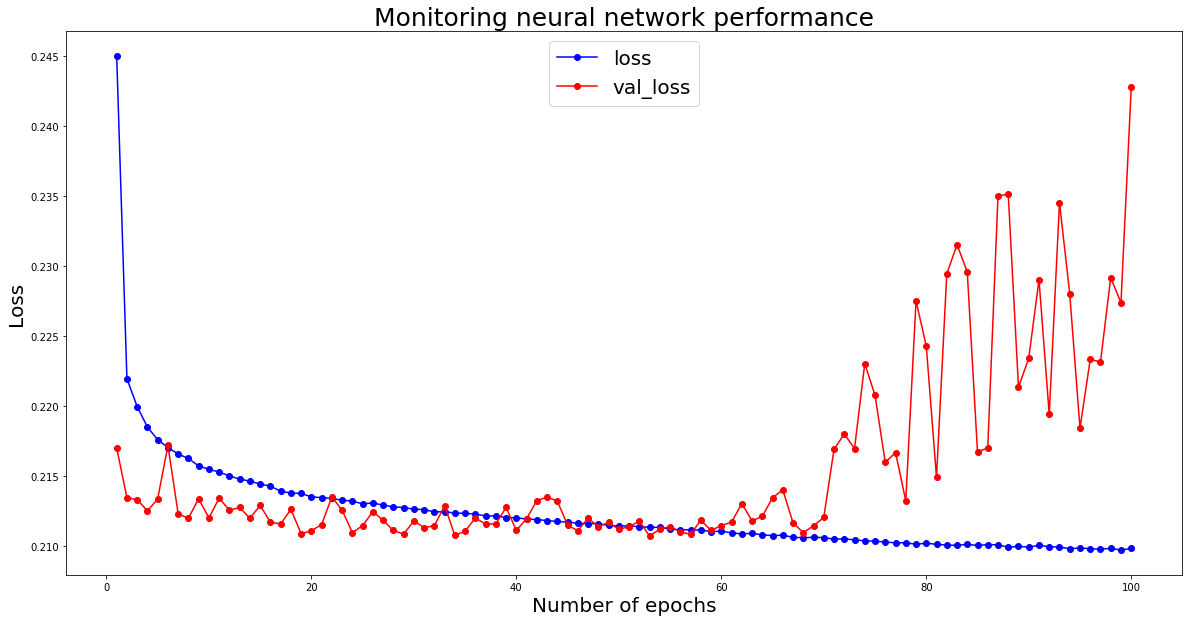

In [179]:
# Improved, Let's increase complexity a bit
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 13s 32us/step - loss: 0.2426 - acc: 0.9058 - val_loss: 0.2168 - val_acc: 0.9181
Epoch 2/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2213 - acc: 0.9131 - val_loss: 0.2156 - val_acc: 0.9190
Epoch 3/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2199 - acc: 0.9135 - val_loss: 0.2170 - val_acc: 0.9171
Epoch 4/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2189 - acc: 0.9142 - val_loss: 0.2144 - val_acc: 0.9184
Epoch 5/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2182 - acc: 0.9144 - val_loss: 0.2134 - val_acc: 0.9188
Epoch 6/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2176 - acc: 0.9146 - val_loss: 0.2131 - val_acc: 0.9189
Epoch 7/100
417611/417611 [==============================] - 12s 28us/step - loss: 0.2173 - acc: 0.914

417611/417611 [==============================] - 11s 26us/step - loss: 0.2109 - acc: 0.9167 - val_loss: 0.2146 - val_acc: 0.9194
Epoch 59/100
417611/417611 [==============================] - 11s 26us/step - loss: 0.2108 - acc: 0.9165 - val_loss: 0.2143 - val_acc: 0.9191
Epoch 60/100
417611/417611 [==============================] - 11s 26us/step - loss: 0.2108 - acc: 0.9166 - val_loss: 0.2166 - val_acc: 0.9182
Epoch 61/100
417611/417611 [==============================] - 11s 26us/step - loss: 0.2107 - acc: 0.9164 - val_loss: 0.2150 - val_acc: 0.9184
Epoch 62/100
417611/417611 [==============================] - 11s 27us/step - loss: 0.2107 - acc: 0.9165 - val_loss: 0.2144 - val_acc: 0.9194
Epoch 63/100
417611/417611 [==============================] - 11s 26us/step - loss: 0.2108 - acc: 0.9166 - val_loss: 0.2194 - val_acc: 0.9196
Epoch 64/100
417611/417611 [==============================] - 11s 26us/step - loss: 0.2106 - acc: 0.9167 - val_loss: 0.2162 - val_acc: 0.9187
Epoch 65/100
417611

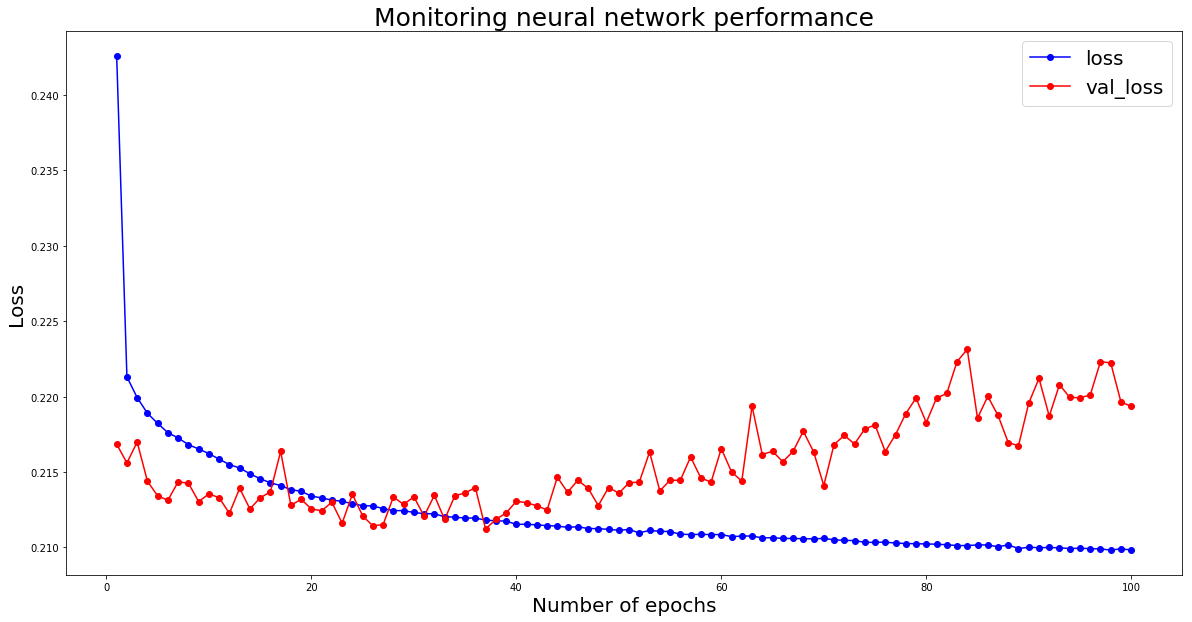

In [180]:
# Improved, Let's increase complexity a bit
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 17s 41us/step - loss: 0.2806 - acc: 0.8939 - val_loss: 0.2187 - val_acc: 0.9186
Epoch 2/100
417611/417611 [==============================] - 14s 34us/step - loss: 0.2427 - acc: 0.9104 - val_loss: 0.2191 - val_acc: 0.9184
Epoch 3/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2389 - acc: 0.9111 - val_loss: 0.2157 - val_acc: 0.9197
Epoch 4/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2377 - acc: 0.9109 - val_loss: 0.2169 - val_acc: 0.9179
Epoch 5/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2365 - acc: 0.9116 - val_loss: 0.2155 - val_acc: 0.9192
Epoch 6/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2353 - acc: 0.9114 - val_loss: 0.2158 - val_acc: 0.9187
Epoch 7/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2353 - acc: 0.911

417611/417611 [==============================] - 14s 32us/step - loss: 0.2298 - acc: 0.9126 - val_loss: 0.2124 - val_acc: 0.9200
Epoch 59/100
417611/417611 [==============================] - 13s 32us/step - loss: 0.2301 - acc: 0.9122 - val_loss: 0.2136 - val_acc: 0.9204
Epoch 60/100
417611/417611 [==============================] - 13s 31us/step - loss: 0.2298 - acc: 0.9124 - val_loss: 0.2127 - val_acc: 0.9201
Epoch 61/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2300 - acc: 0.9119 - val_loss: 0.2124 - val_acc: 0.9195
Epoch 62/100
417611/417611 [==============================] - 13s 32us/step - loss: 0.2297 - acc: 0.9120 - val_loss: 0.2125 - val_acc: 0.9197
Epoch 63/100
417611/417611 [==============================] - 13s 32us/step - loss: 0.2296 - acc: 0.9127 - val_loss: 0.2127 - val_acc: 0.9193
Epoch 64/100
417611/417611 [==============================] - 13s 32us/step - loss: 0.2290 - acc: 0.9124 - val_loss: 0.2116 - val_acc: 0.9203
Epoch 65/100
417611

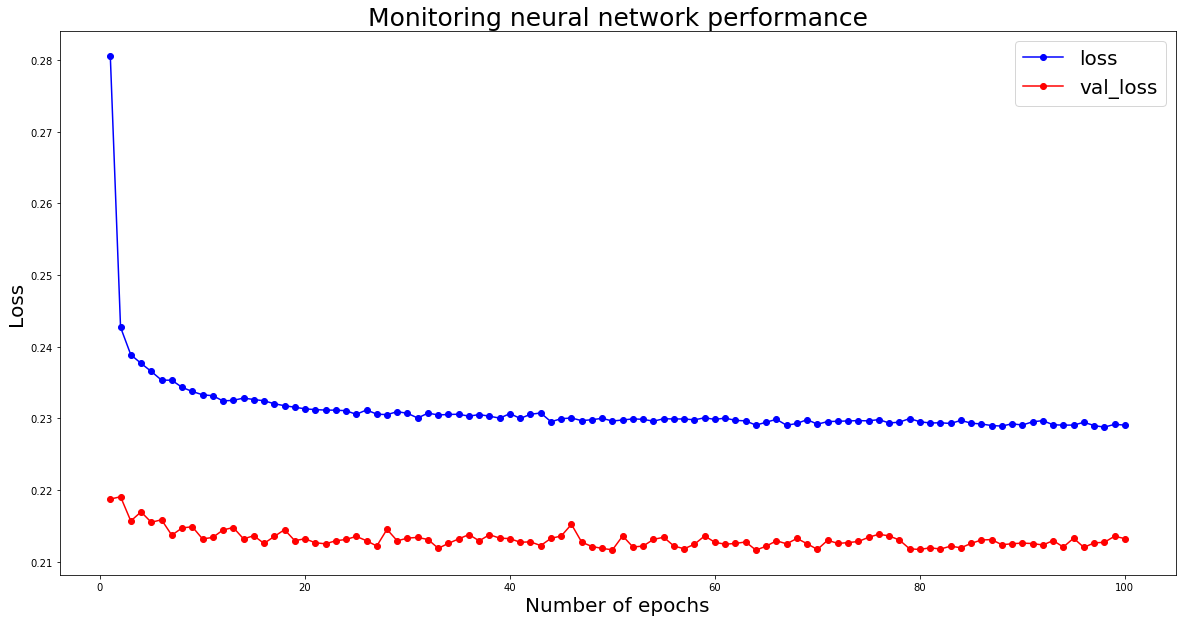

In [181]:
# add dropout layers(model will fit weaker/underfit to training set)
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.2))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.2))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.2))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dropout(0.2))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2483 - acc: 0.9001 - val_loss: 0.2174 - val_acc: 0.9184
Epoch 2/100
417611/417611 [==============================] - 14s 34us/step - loss: 0.2234 - acc: 0.9126 - val_loss: 0.2162 - val_acc: 0.9177
Epoch 3/100
417611/417611 [==============================] - 16s 37us/step - loss: 0.2206 - acc: 0.9133 - val_loss: 0.2146 - val_acc: 0.9192
Epoch 4/100
417611/417611 [==============================] - 15s 35us/step - loss: 0.2191 - acc: 0.9143 - val_loss: 0.2135 - val_acc: 0.9191
Epoch 5/100
417611/417611 [==============================] - 15s 35us/step - loss: 0.2183 - acc: 0.9143 - val_loss: 0.2142 - val_acc: 0.9176
Epoch 6/100
417611/417611 [==============================] - 14s 34us/step - loss: 0.2173 - acc: 0.9147 - val_loss: 0.2176 - val_acc: 0.9157
Epoch 7/100
417611/417611 [==============================] - 15s 37us/step - loss: 0.2167 - acc: 0.915

417611/417611 [==============================] - 15s 37us/step - loss: 0.2115 - acc: 0.9164 - val_loss: 0.2123 - val_acc: 0.9200
Epoch 59/100
417611/417611 [==============================] - 15s 37us/step - loss: 0.2114 - acc: 0.9165 - val_loss: 0.2125 - val_acc: 0.9197
Epoch 60/100
417611/417611 [==============================] - 15s 36us/step - loss: 0.2114 - acc: 0.9164 - val_loss: 0.2120 - val_acc: 0.9194
Epoch 61/100
417611/417611 [==============================] - 15s 37us/step - loss: 0.2114 - acc: 0.9163 - val_loss: 0.2121 - val_acc: 0.9197
Epoch 62/100
417611/417611 [==============================] - 17s 41us/step - loss: 0.2114 - acc: 0.9165 - val_loss: 0.2122 - val_acc: 0.9197
Epoch 63/100
417611/417611 [==============================] - 15s 37us/step - loss: 0.2113 - acc: 0.9162 - val_loss: 0.2120 - val_acc: 0.9200
Epoch 64/100
417611/417611 [==============================] - 15s 36us/step - loss: 0.2114 - acc: 0.9165 - val_loss: 0.2137 - val_acc: 0.9185
Epoch 65/100
417611

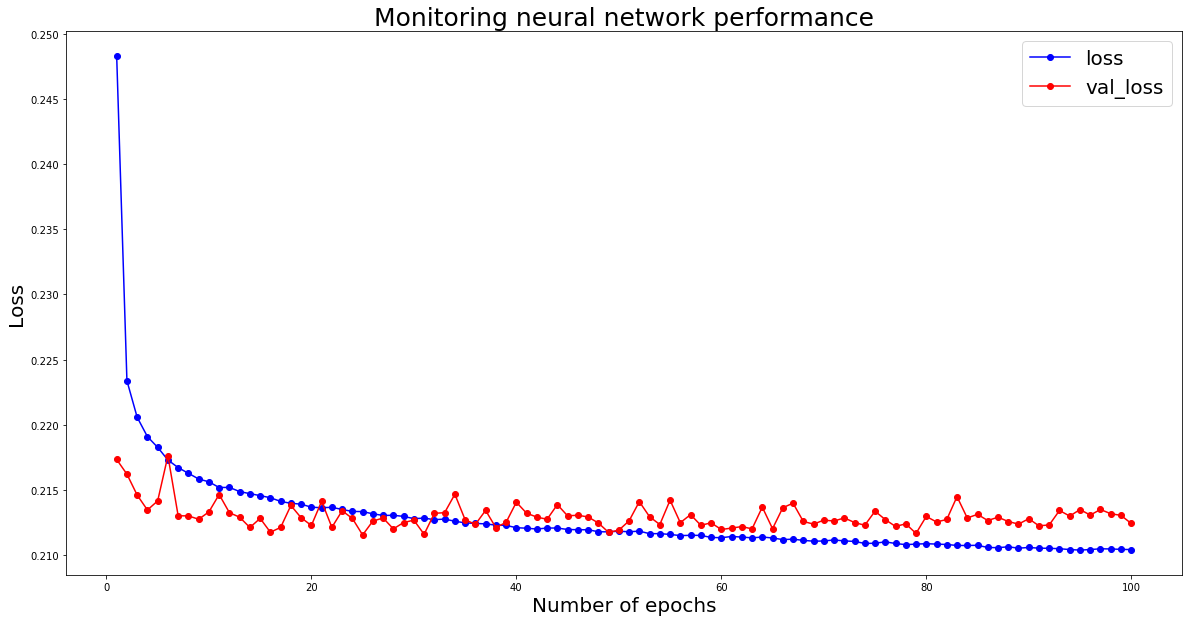

In [184]:
# decrease dropout rate (model will fit stronger to training set)
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Min loss: 0.210405489929 at epoch 95
Min val loss: 0.211566713362 at epoch 25


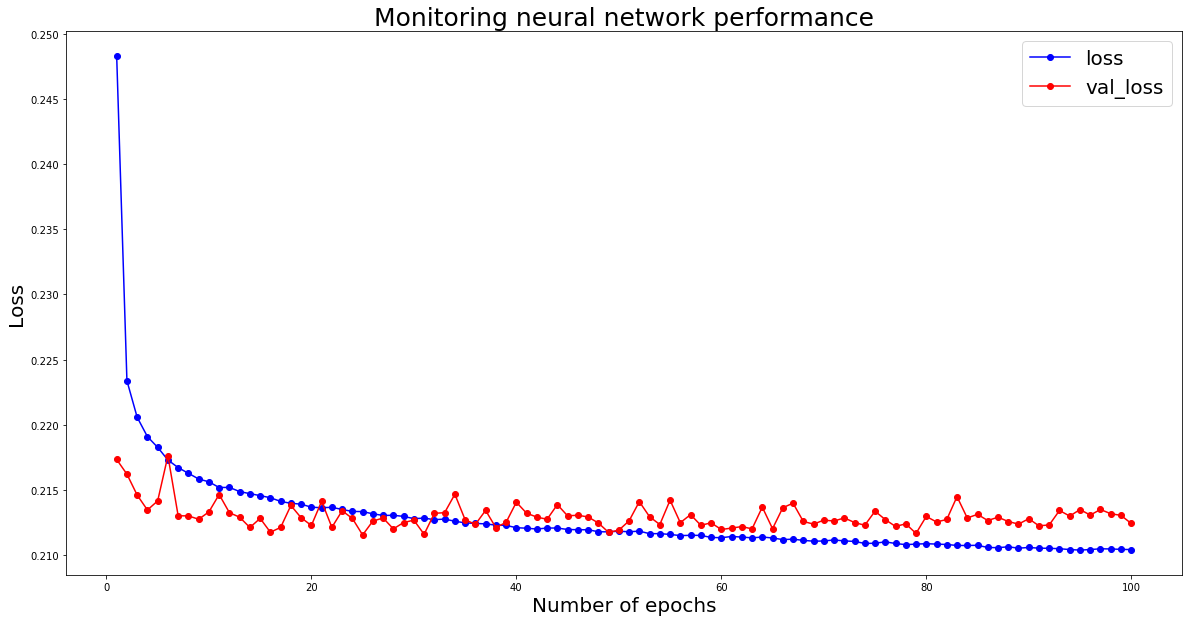

In [185]:
epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2470 - acc: 0.9032 - val_loss: 0.2200 - val_acc: 0.9179
Epoch 2/100
417611/417611 [==============================] - 14s 34us/step - loss: 0.2219 - acc: 0.9128 - val_loss: 0.2158 - val_acc: 0.9185
Epoch 3/100
417611/417611 [==============================] - 15s 36us/step - loss: 0.2197 - acc: 0.9137 - val_loss: 0.2144 - val_acc: 0.9182
Epoch 4/100
417611/417611 [==============================] - 15s 35us/step - loss: 0.2184 - acc: 0.9143 - val_loss: 0.2140 - val_acc: 0.9178
Epoch 5/100
417611/417611 [==============================] - 15s 35us/step - loss: 0.2176 - acc: 0.9144 - val_loss: 0.2198 - val_acc: 0.9147
Epoch 6/100
417611/417611 [==============================] - 14s 34us/step - loss: 0.2169 - acc: 0.9148 - val_loss: 0.2137 - val_acc: 0.9188
Epoch 7/100
417611/417611 [==============================] - 16s 37us/step - loss: 0.2162 - acc: 0.915

417611/417611 [==============================] - 14s 34us/step - loss: 0.2102 - acc: 0.9166 - val_loss: 0.2447 - val_acc: 0.9047
Epoch 59/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2101 - acc: 0.9166 - val_loss: 0.2543 - val_acc: 0.8904
Epoch 60/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2100 - acc: 0.9167 - val_loss: 0.2278 - val_acc: 0.9182
Epoch 61/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2101 - acc: 0.9168 - val_loss: 0.2390 - val_acc: 0.9157
Epoch 62/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2100 - acc: 0.9167 - val_loss: 0.2446 - val_acc: 0.9087
Epoch 63/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2100 - acc: 0.9166 - val_loss: 0.2497 - val_acc: 0.9008
Epoch 64/100
417611/417611 [==============================] - 14s 33us/step - loss: 0.2099 - acc: 0.9167 - val_loss: 0.2420 - val_acc: 0.9135
Epoch 65/100
417611

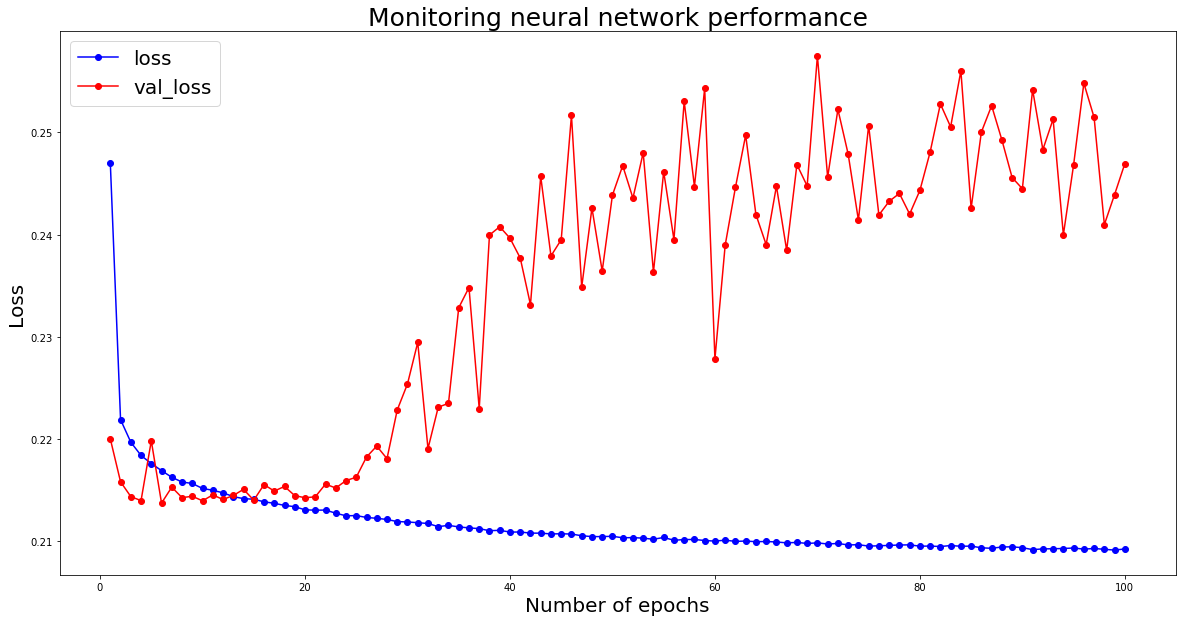

In [186]:
# Increase model complexity to overfit
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2596 - acc: 0.9001 - val_loss: 0.2164 - val_acc: 0.9187
Epoch 2/100
417611/417611 [==============================] - 15s 36us/step - loss: 0.2309 - acc: 0.9119 - val_loss: 0.2174 - val_acc: 0.9182
Epoch 3/100
417611/417611 [==============================] - 25s 59us/step - loss: 0.2278 - acc: 0.9128 - val_loss: 0.2133 - val_acc: 0.9198
Epoch 4/100
417611/417611 [==============================] - 18s 42us/step - loss: 0.2263 - acc: 0.9129 - val_loss: 0.2129 - val_acc: 0.9200
Epoch 5/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2250 - acc: 0.9135 - val_loss: 0.2126 - val_acc: 0.9195
Epoch 6/100
417611/417611 [==============================] - 15s 36us/step - loss: 0.2244 - acc: 0.9136 - val_loss: 0.2146 - val_acc: 0.9189
Epoch 7/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2237 - acc: 0.913

417611/417611 [==============================] - 15s 35us/step - loss: 0.2200 - acc: 0.9148 - val_loss: 0.2111 - val_acc: 0.9203
Epoch 59/100
417611/417611 [==============================] - 14s 35us/step - loss: 0.2197 - acc: 0.9152 - val_loss: 0.2121 - val_acc: 0.9196
Epoch 60/100
417611/417611 [==============================] - 15s 35us/step - loss: 0.2199 - acc: 0.9149 - val_loss: 0.2116 - val_acc: 0.9200
Epoch 61/100
417611/417611 [==============================] - 14s 35us/step - loss: 0.2199 - acc: 0.9149 - val_loss: 0.2123 - val_acc: 0.9198
Epoch 62/100
417611/417611 [==============================] - 14s 34us/step - loss: 0.2198 - acc: 0.9149 - val_loss: 0.2106 - val_acc: 0.9202
Epoch 63/100
417611/417611 [==============================] - 15s 35us/step - loss: 0.2194 - acc: 0.9147 - val_loss: 0.2107 - val_acc: 0.9197
Epoch 64/100
417611/417611 [==============================] - 14s 34us/step - loss: 0.2198 - acc: 0.9149 - val_loss: 0.2113 - val_acc: 0.9198
Epoch 65/100
417611

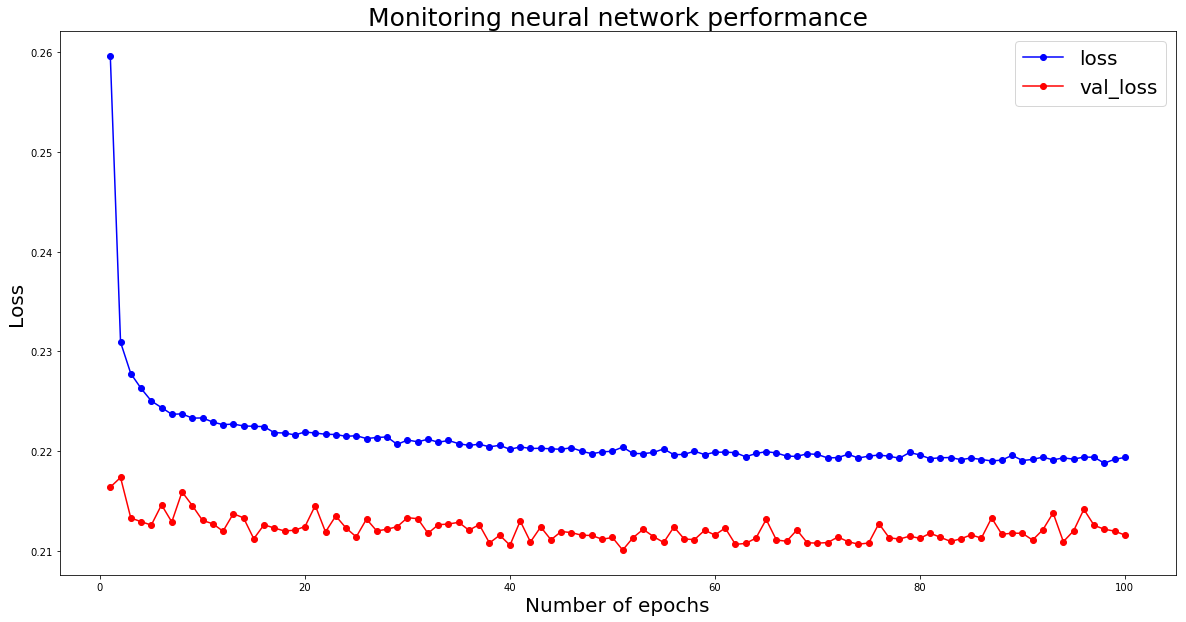

In [187]:
# Increase Dropout rate
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

So far the best performance! Let's increase the dropout rate a little bit more.

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2730 - acc: 0.8938 - val_loss: 0.2163 - val_acc: 0.9196
Epoch 2/100
417611/417611 [==============================] - 15s 36us/step - loss: 0.2375 - acc: 0.9099 - val_loss: 0.2178 - val_acc: 0.9185
Epoch 3/100
417611/417611 [==============================] - 16s 37us/step - loss: 0.2350 - acc: 0.9105 - val_loss: 0.2154 - val_acc: 0.9188
Epoch 4/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2337 - acc: 0.9111 - val_loss: 0.2140 - val_acc: 0.9194
Epoch 5/100
417611/417611 [==============================] - 16s 37us/step - loss: 0.2322 - acc: 0.9117 - val_loss: 0.2150 - val_acc: 0.9200
Epoch 6/100
417611/417611 [==============================] - 15s 37us/step - loss: 0.2301 - acc: 0.9124 - val_loss: 0.2132 - val_acc: 0.9190
Epoch 7/100
417611/417611 [==============================] - 15s 37us/step - loss: 0.2298 - acc: 0.912

417611/417611 [==============================] - 14s 34us/step - loss: 0.2248 - acc: 0.9135 - val_loss: 0.2114 - val_acc: 0.9197
Epoch 59/100
417611/417611 [==============================] - 14s 34us/step - loss: 0.2245 - acc: 0.9140 - val_loss: 0.2116 - val_acc: 0.9201
Epoch 60/100
417611/417611 [==============================] - 16s 37us/step - loss: 0.2247 - acc: 0.9137 - val_loss: 0.2114 - val_acc: 0.9201
Epoch 61/100
417611/417611 [==============================] - 15s 37us/step - loss: 0.2251 - acc: 0.9136 - val_loss: 0.2117 - val_acc: 0.9205
Epoch 62/100
417611/417611 [==============================] - 15s 37us/step - loss: 0.2247 - acc: 0.9140 - val_loss: 0.2113 - val_acc: 0.9194
Epoch 63/100
417611/417611 [==============================] - 15s 37us/step - loss: 0.2246 - acc: 0.9139 - val_loss: 0.2115 - val_acc: 0.9200
Epoch 64/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2244 - acc: 0.9137 - val_loss: 0.2116 - val_acc: 0.9189
Epoch 65/100
417611

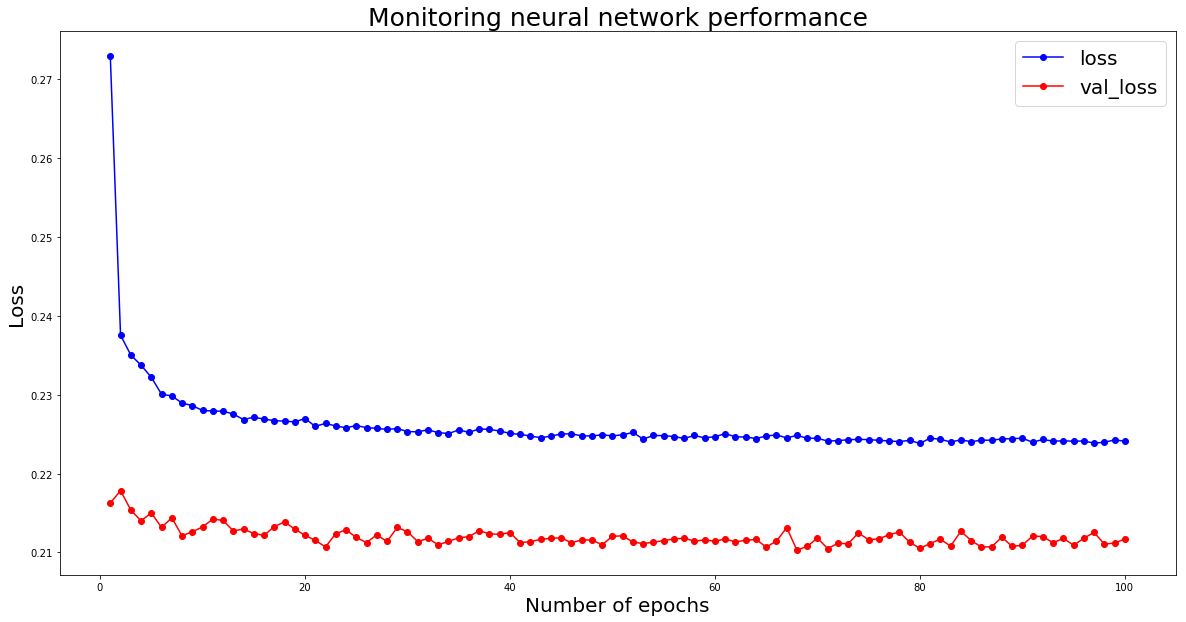

In [188]:
# Increase Dropout rate
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.15))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.15))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.15))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dropout(0.15))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2390 - acc: 0.9074 - val_loss: 0.2163 - val_acc: 0.9182
Epoch 2/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2202 - acc: 0.9137 - val_loss: 0.2187 - val_acc: 0.9158
Epoch 3/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2186 - acc: 0.9142 - val_loss: 0.2183 - val_acc: 0.9157
Epoch 4/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2175 - acc: 0.9147 - val_loss: 0.2137 - val_acc: 0.9184
Epoch 5/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2167 - acc: 0.9147 - val_loss: 0.2136 - val_acc: 0.9186
Epoch 6/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2162 - acc: 0.9150 - val_loss: 0.2136 - val_acc: 0.9187
Epoch 7/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2157 - acc: 0.915

417611/417611 [==============================] - 17s 41us/step - loss: 0.2100 - acc: 0.9169 - val_loss: 0.2131 - val_acc: 0.9189
Epoch 59/100
417611/417611 [==============================] - 17s 42us/step - loss: 0.2099 - acc: 0.9168 - val_loss: 0.2121 - val_acc: 0.9193
Epoch 60/100
417611/417611 [==============================] - 17s 41us/step - loss: 0.2099 - acc: 0.9167 - val_loss: 0.2132 - val_acc: 0.9192
Epoch 61/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2100 - acc: 0.9169 - val_loss: 0.2129 - val_acc: 0.9187
Epoch 62/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2098 - acc: 0.9168 - val_loss: 0.2115 - val_acc: 0.9194
Epoch 63/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2099 - acc: 0.9168 - val_loss: 0.2128 - val_acc: 0.9182
Epoch 64/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2098 - acc: 0.9170 - val_loss: 0.2120 - val_acc: 0.9193
Epoch 65/100
417611

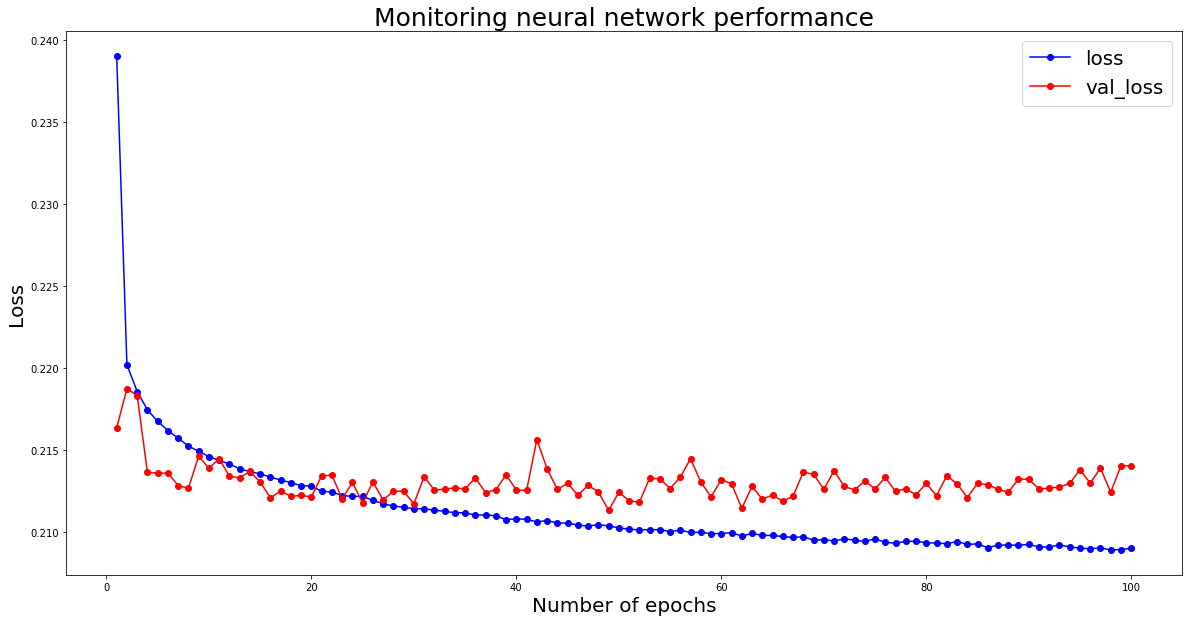

In [191]:
# Decrease Dropout rate
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 20s 47us/step - loss: 0.2399 - acc: 0.9040 - val_loss: 0.2180 - val_acc: 0.9165
Epoch 2/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2213 - acc: 0.9131 - val_loss: 0.2157 - val_acc: 0.9171
Epoch 3/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2195 - acc: 0.9137 - val_loss: 0.2172 - val_acc: 0.9172
Epoch 4/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2186 - acc: 0.9141 - val_loss: 0.2138 - val_acc: 0.9187
Epoch 5/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2177 - acc: 0.9146 - val_loss: 0.2153 - val_acc: 0.9187
Epoch 6/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2170 - acc: 0.9149 - val_loss: 0.2127 - val_acc: 0.9196
Epoch 7/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2164 - acc: 0.915

417611/417611 [==============================] - 16s 38us/step - loss: 0.2097 - acc: 0.9169 - val_loss: 0.2196 - val_acc: 0.9186
Epoch 59/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2096 - acc: 0.9171 - val_loss: 0.2159 - val_acc: 0.9191
Epoch 60/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2096 - acc: 0.9168 - val_loss: 0.2171 - val_acc: 0.9186
Epoch 61/100
417611/417611 [==============================] - 17s 41us/step - loss: 0.2094 - acc: 0.9169 - val_loss: 0.2166 - val_acc: 0.9185
Epoch 62/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2094 - acc: 0.9170 - val_loss: 0.2138 - val_acc: 0.9181
Epoch 63/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2096 - acc: 0.9170 - val_loss: 0.2213 - val_acc: 0.9186
Epoch 64/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2094 - acc: 0.9170 - val_loss: 0.2208 - val_acc: 0.9180
Epoch 65/100
417611

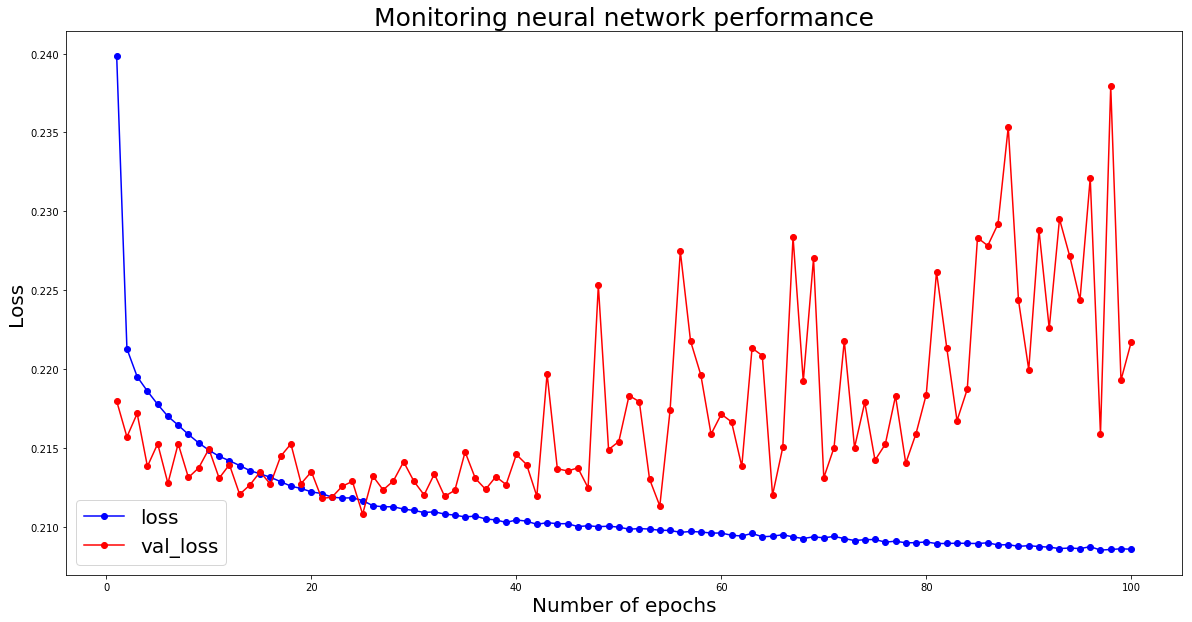

In [192]:
# Increase Model Complexity to overfit
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.001))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 24s 58us/step - loss: 0.2519 - acc: 0.9023 - val_loss: 0.2159 - val_acc: 0.9187
Epoch 2/100
417611/417611 [==============================] - 17s 41us/step - loss: 0.2279 - acc: 0.9123 - val_loss: 0.2141 - val_acc: 0.9195
Epoch 3/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2253 - acc: 0.9129 - val_loss: 0.2151 - val_acc: 0.9188
Epoch 4/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2235 - acc: 0.9134 - val_loss: 0.2131 - val_acc: 0.9195
Epoch 5/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2228 - acc: 0.9140 - val_loss: 0.2131 - val_acc: 0.9200
Epoch 6/100
417611/417611 [==============================] - 17s 40us/step - loss: 0.2217 - acc: 0.9139 - val_loss: 0.2128 - val_acc: 0.9192
Epoch 7/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2212 - acc: 0.914

417611/417611 [==============================] - 16s 38us/step - loss: 0.2165 - acc: 0.9152 - val_loss: 0.2118 - val_acc: 0.9205
Epoch 59/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2166 - acc: 0.9154 - val_loss: 0.2108 - val_acc: 0.9203
Epoch 60/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2168 - acc: 0.9154 - val_loss: 0.2113 - val_acc: 0.9204
Epoch 61/100
417611/417611 [==============================] - 16s 38us/step - loss: 0.2166 - acc: 0.9153 - val_loss: 0.2117 - val_acc: 0.9201
Epoch 62/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2165 - acc: 0.9153 - val_loss: 0.2114 - val_acc: 0.9203
Epoch 63/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2164 - acc: 0.9155 - val_loss: 0.2114 - val_acc: 0.9204
Epoch 64/100
417611/417611 [==============================] - 16s 39us/step - loss: 0.2165 - acc: 0.9153 - val_loss: 0.2110 - val_acc: 0.9206
Epoch 65/100
417611

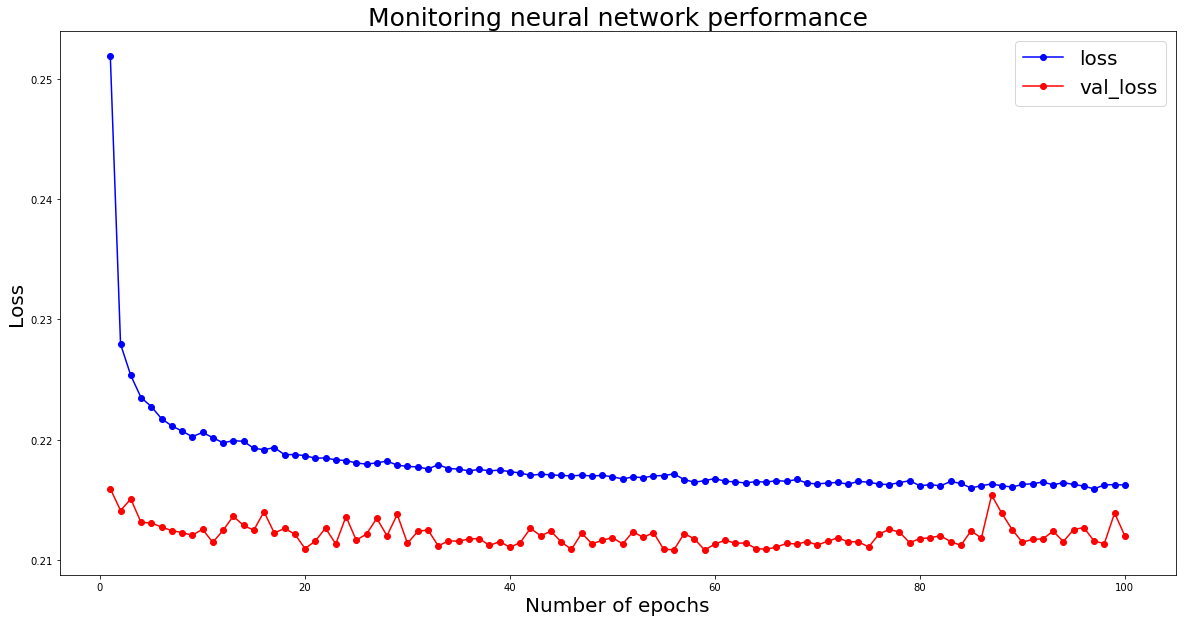

In [193]:
# Increase Dropout rate
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 21s 50us/step - loss: 0.2365 - acc: 0.9064 - val_loss: 0.2138 - val_acc: 0.9188
Epoch 2/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2200 - acc: 0.9135 - val_loss: 0.2156 - val_acc: 0.9179
Epoch 3/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2176 - acc: 0.9147 - val_loss: 0.2125 - val_acc: 0.9197
Epoch 4/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2168 - acc: 0.9149 - val_loss: 0.2130 - val_acc: 0.9190
Epoch 5/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2158 - acc: 0.9150 - val_loss: 0.2123 - val_acc: 0.9188
Epoch 6/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2153 - acc: 0.9153 - val_loss: 0.2124 - val_acc: 0.9197
Epoch 7/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2148 - acc: 0.915

417611/417611 [==============================] - 18s 42us/step - loss: 0.2088 - acc: 0.9171 - val_loss: 0.2326 - val_acc: 0.9192
Epoch 59/100
417611/417611 [==============================] - 18s 42us/step - loss: 0.2090 - acc: 0.9169 - val_loss: 0.2279 - val_acc: 0.9185
Epoch 60/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2090 - acc: 0.9169 - val_loss: 0.2234 - val_acc: 0.9179
Epoch 61/100
417611/417611 [==============================] - 18s 42us/step - loss: 0.2090 - acc: 0.9170 - val_loss: 0.2218 - val_acc: 0.9197
Epoch 62/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2090 - acc: 0.9169 - val_loss: 0.2314 - val_acc: 0.9190
Epoch 63/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2087 - acc: 0.9171 - val_loss: 0.2312 - val_acc: 0.9188
Epoch 64/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2089 - acc: 0.9170 - val_loss: 0.2356 - val_acc: 0.9189
Epoch 65/100
417611

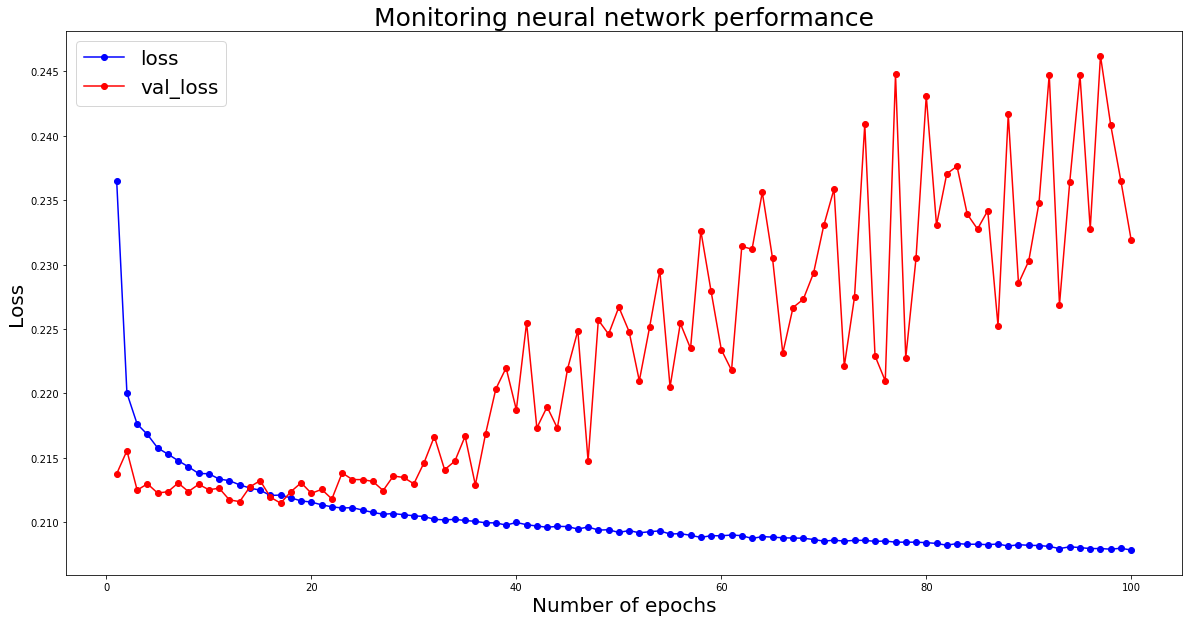

In [195]:
# Increase Complexity
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(32,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.01))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.01))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.01))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.01))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 22s 54us/step - loss: 0.2472 - acc: 0.9038 - val_loss: 0.2141 - val_acc: 0.9191
Epoch 2/100
417611/417611 [==============================] - 25s 60us/step - loss: 0.2248 - acc: 0.9127 - val_loss: 0.2130 - val_acc: 0.9196
Epoch 3/100
417611/417611 [==============================] - 21s 51us/step - loss: 0.2222 - acc: 0.9136 - val_loss: 0.2135 - val_acc: 0.9188
Epoch 4/100
417611/417611 [==============================] - 19s 45us/step - loss: 0.2207 - acc: 0.9143 - val_loss: 0.2123 - val_acc: 0.9187
Epoch 5/100
417611/417611 [==============================] - 19s 45us/step - loss: 0.2197 - acc: 0.9145 - val_loss: 0.2116 - val_acc: 0.9201
Epoch 6/100
417611/417611 [==============================] - 19s 47us/step - loss: 0.2191 - acc: 0.9146 - val_loss: 0.2113 - val_acc: 0.9199
Epoch 7/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2186 - acc: 0.914

417611/417611 [==============================] - 18s 44us/step - loss: 0.2138 - acc: 0.9161 - val_loss: 0.2131 - val_acc: 0.9199
Epoch 59/100
417611/417611 [==============================] - 18s 44us/step - loss: 0.2136 - acc: 0.9161 - val_loss: 0.2113 - val_acc: 0.9190
Epoch 60/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2135 - acc: 0.9161 - val_loss: 0.2125 - val_acc: 0.9190
Epoch 61/100
417611/417611 [==============================] - 18s 44us/step - loss: 0.2138 - acc: 0.9161 - val_loss: 0.2116 - val_acc: 0.9198
Epoch 62/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2137 - acc: 0.9162 - val_loss: 0.2117 - val_acc: 0.9203
Epoch 63/100
417611/417611 [==============================] - 18s 44us/step - loss: 0.2138 - acc: 0.9161 - val_loss: 0.2112 - val_acc: 0.9202
Epoch 64/100
417611/417611 [==============================] - 18s 44us/step - loss: 0.2136 - acc: 0.9160 - val_loss: 0.2129 - val_acc: 0.9199
Epoch 65/100
417611

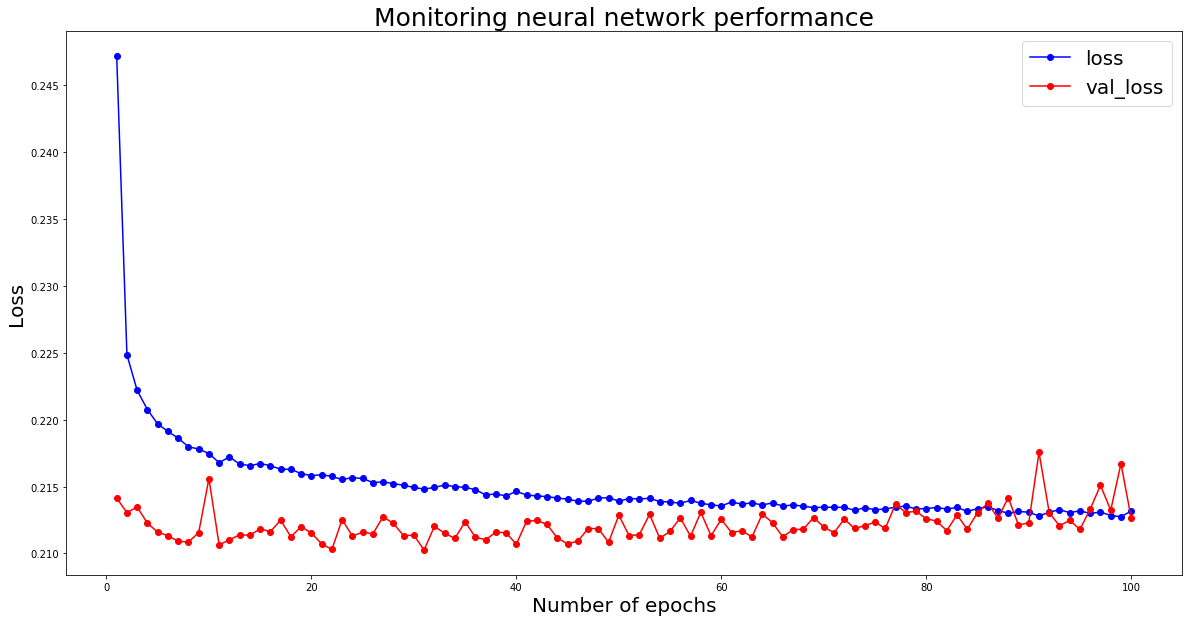

In [196]:
# Increase dropout rate
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(32,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 25s 61us/step - loss: 0.2480 - acc: 0.9031 - val_loss: 0.2160 - val_acc: 0.9179
Epoch 2/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2252 - acc: 0.9133 - val_loss: 0.2148 - val_acc: 0.9188
Epoch 3/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2225 - acc: 0.9137 - val_loss: 0.2126 - val_acc: 0.9191
Epoch 4/100
417611/417611 [==============================] - 18s 44us/step - loss: 0.2210 - acc: 0.9141 - val_loss: 0.2132 - val_acc: 0.9193
Epoch 5/100
417611/417611 [==============================] - 18s 44us/step - loss: 0.2206 - acc: 0.9142 - val_loss: 0.2148 - val_acc: 0.9186
Epoch 6/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2196 - acc: 0.9148 - val_loss: 0.2130 - val_acc: 0.9189
Epoch 7/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2191 - acc: 0.914

417611/417611 [==============================] - 18s 44us/step - loss: 0.2144 - acc: 0.9164 - val_loss: 0.2134 - val_acc: 0.9179
Epoch 59/100
417611/417611 [==============================] - 18s 44us/step - loss: 0.2147 - acc: 0.9162 - val_loss: 0.2131 - val_acc: 0.9186
Epoch 60/100
417611/417611 [==============================] - 18s 44us/step - loss: 0.2144 - acc: 0.9163 - val_loss: 0.2125 - val_acc: 0.9192
Epoch 61/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2143 - acc: 0.9161 - val_loss: 0.2126 - val_acc: 0.9184
Epoch 62/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2142 - acc: 0.9162 - val_loss: 0.2134 - val_acc: 0.9185
Epoch 63/100
417611/417611 [==============================] - 18s 43us/step - loss: 0.2144 - acc: 0.9160 - val_loss: 0.2130 - val_acc: 0.9187
Epoch 64/100
417611/417611 [==============================] - 18s 44us/step - loss: 0.2142 - acc: 0.9159 - val_loss: 0.2119 - val_acc: 0.9187
Epoch 65/100
417611

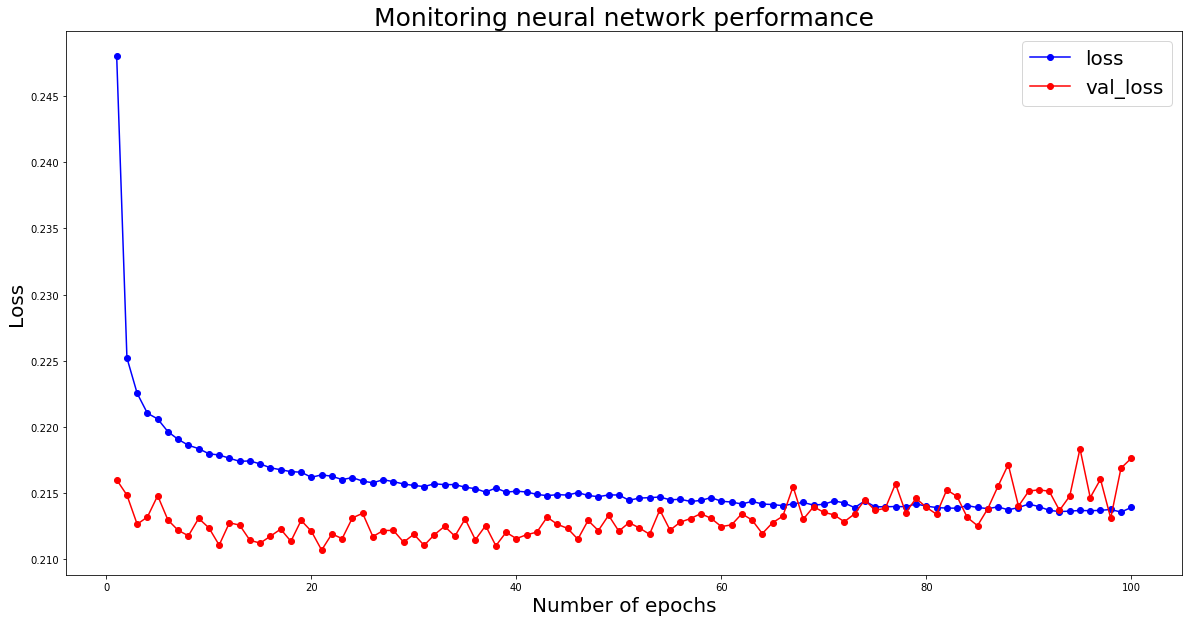

In [197]:
# Slightly Increase dropout rate
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(32,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.12))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.12))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.12))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.12))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 24s 57us/step - loss: 0.2456 - acc: 0.9039 - val_loss: 0.2150 - val_acc: 0.9193
Epoch 2/100
417611/417611 [==============================] - 19s 45us/step - loss: 0.2236 - acc: 0.9131 - val_loss: 0.2134 - val_acc: 0.9194
Epoch 3/100
417611/417611 [==============================] - 19s 46us/step - loss: 0.2207 - acc: 0.9139 - val_loss: 0.2132 - val_acc: 0.9189
Epoch 4/100
417611/417611 [==============================] - 19s 46us/step - loss: 0.2192 - acc: 0.9142 - val_loss: 0.2122 - val_acc: 0.9189
Epoch 5/100
417611/417611 [==============================] - 19s 45us/step - loss: 0.2184 - acc: 0.9143 - val_loss: 0.2125 - val_acc: 0.9194
Epoch 6/100
417611/417611 [==============================] - 19s 45us/step - loss: 0.2180 - acc: 0.9147 - val_loss: 0.2123 - val_acc: 0.9192
Epoch 7/100
417611/417611 [==============================] - 19s 45us/step - loss: 0.2172 - acc: 0.914

417611/417611 [==============================] - 19s 46us/step - loss: 0.2124 - acc: 0.9164 - val_loss: 0.2113 - val_acc: 0.9183
Epoch 59/100
417611/417611 [==============================] - 18s 44us/step - loss: 0.2126 - acc: 0.9162 - val_loss: 0.2121 - val_acc: 0.9178
Epoch 60/100
417611/417611 [==============================] - 19s 45us/step - loss: 0.2125 - acc: 0.9164 - val_loss: 0.2119 - val_acc: 0.9188
Epoch 61/100
417611/417611 [==============================] - 19s 45us/step - loss: 0.2124 - acc: 0.9162 - val_loss: 0.2130 - val_acc: 0.9186
Epoch 62/100
417611/417611 [==============================] - 19s 44us/step - loss: 0.2124 - acc: 0.9166 - val_loss: 0.2121 - val_acc: 0.9185
Epoch 63/100
417611/417611 [==============================] - 18s 44us/step - loss: 0.2125 - acc: 0.9163 - val_loss: 0.2129 - val_acc: 0.9192
Epoch 64/100
417611/417611 [==============================] - 19s 46us/step - loss: 0.2123 - acc: 0.9165 - val_loss: 0.2123 - val_acc: 0.9185
Epoch 65/100
417611

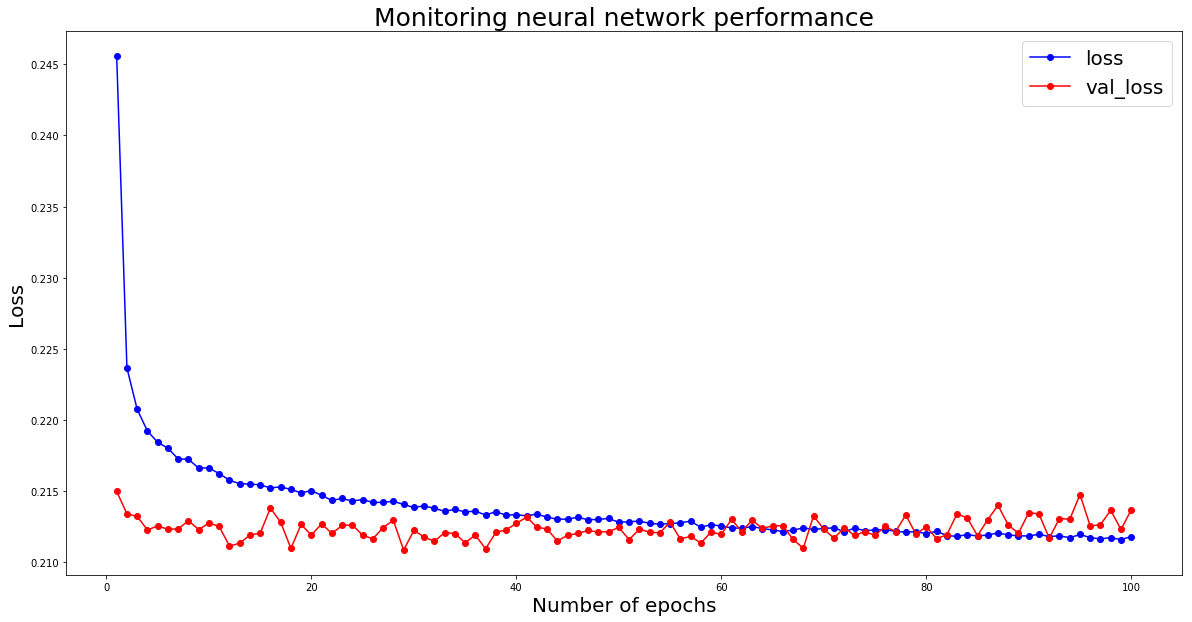

In [198]:
# Slightly decrease dropout rate
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(32,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.08))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.08))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.08))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.08))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 26s 62us/step - loss: 0.2419 - acc: 0.9058 - val_loss: 0.2151 - val_acc: 0.9190
Epoch 2/100
417611/417611 [==============================] - 21s 51us/step - loss: 0.2228 - acc: 0.9132 - val_loss: 0.2158 - val_acc: 0.9174
Epoch 3/100
417611/417611 [==============================] - 20s 49us/step - loss: 0.2202 - acc: 0.9140 - val_loss: 0.2163 - val_acc: 0.9174
Epoch 4/100
417611/417611 [==============================] - 25s 60us/step - loss: 0.2189 - acc: 0.9147 - val_loss: 0.2118 - val_acc: 0.9198
Epoch 5/100
417611/417611 [==============================] - 24s 58us/step - loss: 0.2182 - acc: 0.9148 - val_loss: 0.2128 - val_acc: 0.9187
Epoch 6/100
417611/417611 [==============================] - 24s 57us/step - loss: 0.2174 - acc: 0.9153 - val_loss: 0.2131 - val_acc: 0.9201
Epoch 7/100
417611/417611 [==============================] - 22s 52us/step - loss: 0.2173 - acc: 0.915

417611/417611 [==============================] - 20s 47us/step - loss: 0.2125 - acc: 0.9162 - val_loss: 0.2123 - val_acc: 0.9191
Epoch 59/100
417611/417611 [==============================] - 20s 47us/step - loss: 0.2124 - acc: 0.9165 - val_loss: 0.2114 - val_acc: 0.9198
Epoch 60/100
417611/417611 [==============================] - 20s 47us/step - loss: 0.2126 - acc: 0.9165 - val_loss: 0.2104 - val_acc: 0.9204
Epoch 61/100
417611/417611 [==============================] - 19s 47us/step - loss: 0.2124 - acc: 0.9165 - val_loss: 0.2108 - val_acc: 0.9195
Epoch 62/100
417611/417611 [==============================] - 19s 47us/step - loss: 0.2123 - acc: 0.9167 - val_loss: 0.2113 - val_acc: 0.9195
Epoch 63/100
417611/417611 [==============================] - 20s 47us/step - loss: 0.2124 - acc: 0.9165 - val_loss: 0.2110 - val_acc: 0.9197
Epoch 64/100
417611/417611 [==============================] - 20s 47us/step - loss: 0.2120 - acc: 0.9164 - val_loss: 0.2103 - val_acc: 0.9199
Epoch 65/100
417611

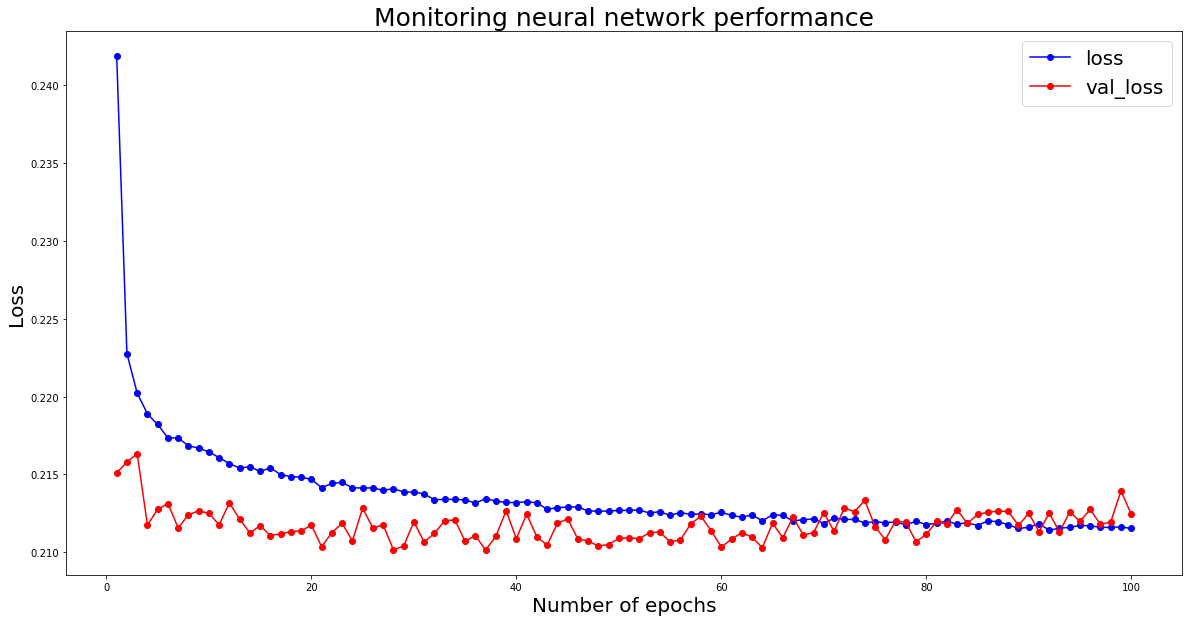

In [199]:
# Slightly increase model complexity to overfit
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(32,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.08))
network1.add(layers.Dense(48,activation="relu"))
network1.add(layers.Dropout(0.08))
network1.add(layers.Dense(48,activation="relu"))
network1.add(layers.Dropout(0.08))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.08))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 23s 56us/step - loss: 0.2458 - acc: 0.9034 - val_loss: 0.2155 - val_acc: 0.9190
Epoch 2/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2240 - acc: 0.9126 - val_loss: 0.2144 - val_acc: 0.9188
Epoch 3/100
417611/417611 [==============================] - 20s 49us/step - loss: 0.2217 - acc: 0.9136 - val_loss: 0.2137 - val_acc: 0.9199
Epoch 4/100
417611/417611 [==============================] - 20s 49us/step - loss: 0.2201 - acc: 0.9142 - val_loss: 0.2125 - val_acc: 0.9184
Epoch 5/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2194 - acc: 0.9144 - val_loss: 0.2122 - val_acc: 0.9195
Epoch 6/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2186 - acc: 0.9147 - val_loss: 0.2134 - val_acc: 0.9185
Epoch 7/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2183 - acc: 0.915

417611/417611 [==============================] - 20s 48us/step - loss: 0.2132 - acc: 0.9163 - val_loss: 0.2121 - val_acc: 0.9201
Epoch 59/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2132 - acc: 0.9163 - val_loss: 0.2142 - val_acc: 0.9192
Epoch 60/100
417611/417611 [==============================] - 20s 47us/step - loss: 0.2131 - acc: 0.9161 - val_loss: 0.2137 - val_acc: 0.9186
Epoch 61/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2130 - acc: 0.9163 - val_loss: 0.2135 - val_acc: 0.9189
Epoch 62/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2128 - acc: 0.9163 - val_loss: 0.2130 - val_acc: 0.9188
Epoch 63/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2131 - acc: 0.9162 - val_loss: 0.2132 - val_acc: 0.9195
Epoch 64/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2130 - acc: 0.9164 - val_loss: 0.2126 - val_acc: 0.9198
Epoch 65/100
417611

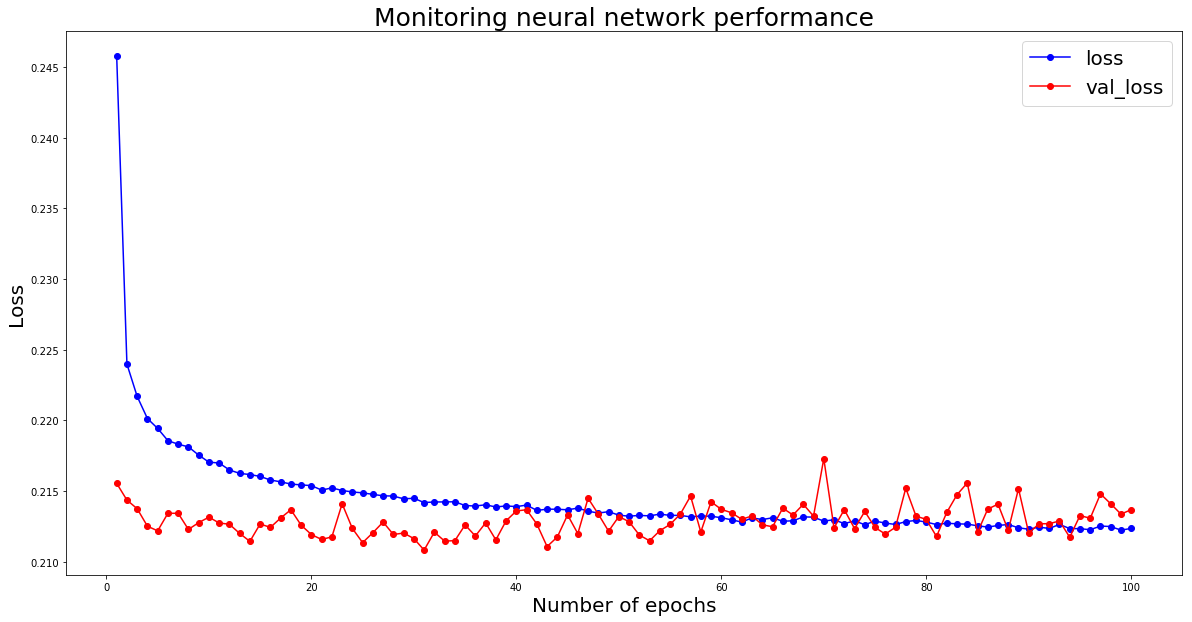

In [200]:
# Slightly increase dropout rate
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(32,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(48,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(48,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 22s 52us/step - loss: 0.2384 - acc: 0.9074 - val_loss: 0.2168 - val_acc: 0.9190
Epoch 2/100
417611/417611 [==============================] - 19s 46us/step - loss: 0.2215 - acc: 0.9138 - val_loss: 0.2193 - val_acc: 0.9150
Epoch 3/100
417611/417611 [==============================] - 19s 46us/step - loss: 0.2195 - acc: 0.9145 - val_loss: 0.2196 - val_acc: 0.9135
Epoch 4/100
417611/417611 [==============================] - 19s 46us/step - loss: 0.2184 - acc: 0.9149 - val_loss: 0.2153 - val_acc: 0.9180
Epoch 5/100
417611/417611 [==============================] - 19s 47us/step - loss: 0.2174 - acc: 0.9154 - val_loss: 0.2149 - val_acc: 0.9176
Epoch 6/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2167 - acc: 0.9152 - val_loss: 0.2146 - val_acc: 0.9196
Epoch 7/100
417611/417611 [==============================] - 22s 53us/step - loss: 0.2161 - acc: 0.915

417611/417611 [==============================] - 20s 47us/step - loss: 0.2105 - acc: 0.9167 - val_loss: 0.2278 - val_acc: 0.9183
Epoch 59/100
417611/417611 [==============================] - 20s 47us/step - loss: 0.2104 - acc: 0.9168 - val_loss: 0.2475 - val_acc: 0.8905
Epoch 60/100
417611/417611 [==============================] - 20s 47us/step - loss: 0.2103 - acc: 0.9169 - val_loss: 0.2477 - val_acc: 0.8949
Epoch 61/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2102 - acc: 0.9170 - val_loss: 0.2513 - val_acc: 0.8920
Epoch 62/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2103 - acc: 0.9168 - val_loss: 0.2278 - val_acc: 0.9158
Epoch 63/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2101 - acc: 0.9170 - val_loss: 0.2354 - val_acc: 0.9154
Epoch 64/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2103 - acc: 0.9170 - val_loss: 0.2300 - val_acc: 0.9158
Epoch 65/100
417611

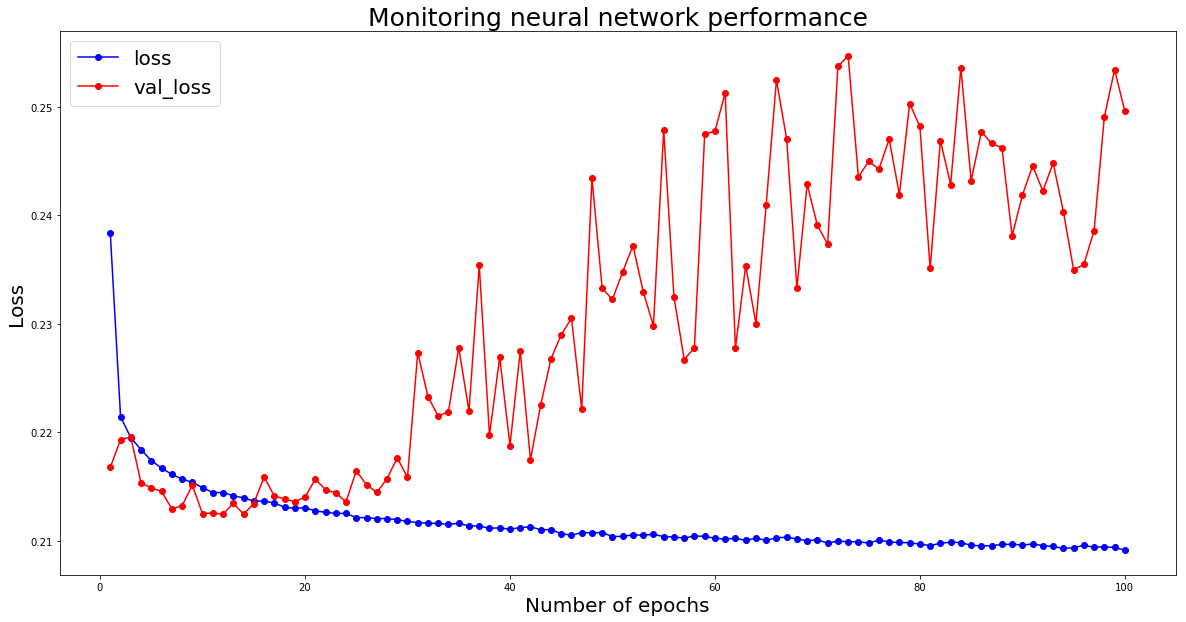

In [201]:
# Remove one dropout layer
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(32,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
#network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(48,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(48,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Min loss: 0.209159791895 at epoch 100
Min val loss: 0.212455943731 at epoch 12


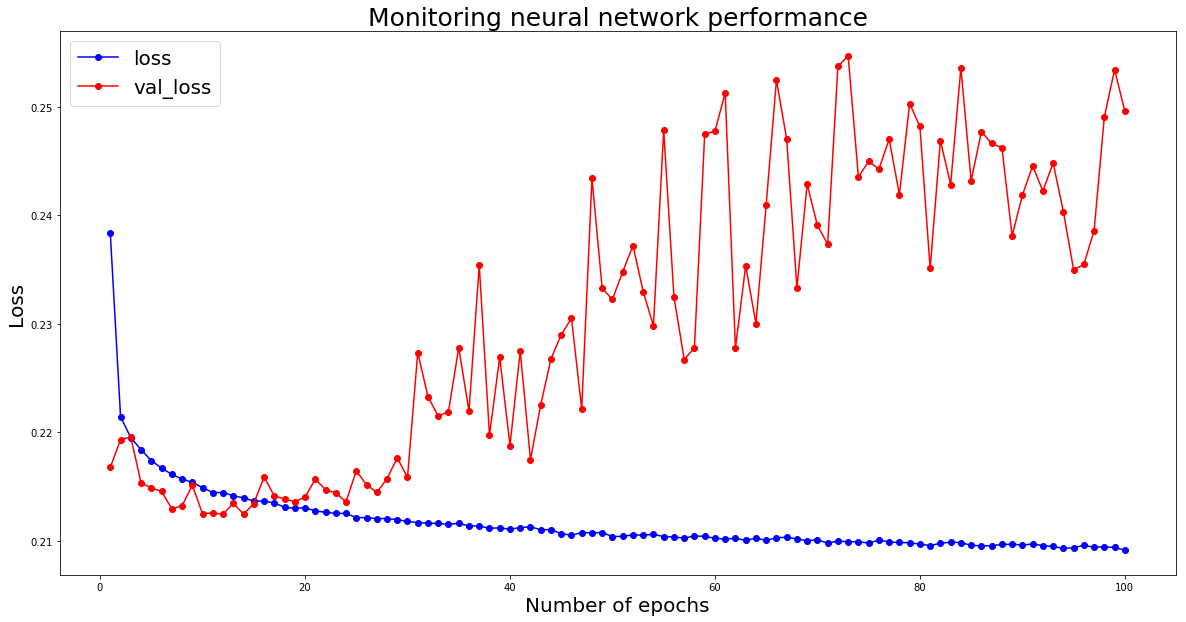

In [202]:
epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 25s 60us/step - loss: 0.2863 - acc: 0.8915 - val_loss: 0.2177 - val_acc: 0.9188
Epoch 2/100
417611/417611 [==============================] - 20s 48us/step - loss: 0.2415 - acc: 0.9101 - val_loss: 0.2208 - val_acc: 0.9162
Epoch 3/100
417611/417611 [==============================] - 21s 50us/step - loss: 0.2367 - acc: 0.9104 - val_loss: 0.2174 - val_acc: 0.9185
Epoch 4/100
417611/417611 [==============================] - 22s 53us/step - loss: 0.2351 - acc: 0.9105 - val_loss: 0.2175 - val_acc: 0.9194
Epoch 5/100
417611/417611 [==============================] - 23s 54us/step - loss: 0.2343 - acc: 0.9107 - val_loss: 0.2154 - val_acc: 0.9194
Epoch 6/100
417611/417611 [==============================] - 22s 52us/step - loss: 0.2331 - acc: 0.9109 - val_loss: 0.2146 - val_acc: 0.9188
Epoch 7/100
417611/417611 [==============================] - 22s 53us/step - loss: 0.2323 - acc: 0.911

417611/417611 [==============================] - 22s 52us/step - loss: 0.2272 - acc: 0.9121 - val_loss: 0.2133 - val_acc: 0.9193
Epoch 59/100
417611/417611 [==============================] - 21s 50us/step - loss: 0.2272 - acc: 0.9120 - val_loss: 0.2122 - val_acc: 0.9198
Epoch 60/100
417611/417611 [==============================] - 21s 51us/step - loss: 0.2273 - acc: 0.9119 - val_loss: 0.2145 - val_acc: 0.9201
Epoch 61/100
417611/417611 [==============================] - 22s 53us/step - loss: 0.2269 - acc: 0.9118 - val_loss: 0.2134 - val_acc: 0.9202
Epoch 62/100
417611/417611 [==============================] - 21s 50us/step - loss: 0.2268 - acc: 0.9121 - val_loss: 0.2117 - val_acc: 0.9203
Epoch 63/100
417611/417611 [==============================] - 22s 52us/step - loss: 0.2267 - acc: 0.9123 - val_loss: 0.2130 - val_acc: 0.9192
Epoch 64/100
417611/417611 [==============================] - 22s 52us/step - loss: 0.2272 - acc: 0.9122 - val_loss: 0.2137 - val_acc: 0.9206
Epoch 65/100
417611

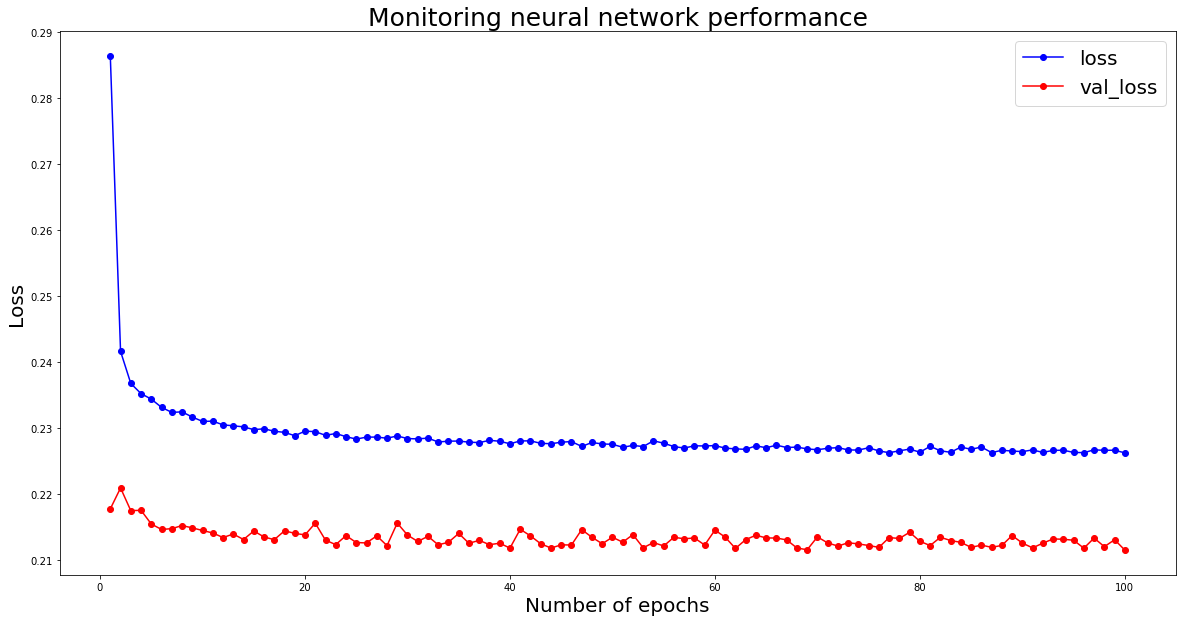

In [220]:
# Increase Dropout rate
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(4,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 25s 60us/step - loss: 0.2631 - acc: 0.8994 - val_loss: 0.2165 - val_acc: 0.9188
Epoch 2/100
417611/417611 [==============================] - 21s 50us/step - loss: 0.2318 - acc: 0.9123 - val_loss: 0.2135 - val_acc: 0.9190
Epoch 3/100
417611/417611 [==============================] - 21s 50us/step - loss: 0.2289 - acc: 0.9129 - val_loss: 0.2139 - val_acc: 0.9189
Epoch 4/100
417611/417611 [==============================] - 21s 51us/step - loss: 0.2273 - acc: 0.9131 - val_loss: 0.2131 - val_acc: 0.9188
Epoch 5/100
417611/417611 [==============================] - 23s 56us/step - loss: 0.2259 - acc: 0.9133 - val_loss: 0.2124 - val_acc: 0.9193
Epoch 6/100
417611/417611 [==============================] - 24s 58us/step - loss: 0.2249 - acc: 0.9135 - val_loss: 0.2141 - val_acc: 0.9193
Epoch 7/100
417611/417611 [==============================] - 29s 70us/step - loss: 0.2243 - acc: 0.913

417611/417611 [==============================] - 20s 49us/step - loss: 0.2198 - acc: 0.9145 - val_loss: 0.2131 - val_acc: 0.9199
Epoch 59/100
417611/417611 [==============================] - 20s 49us/step - loss: 0.2195 - acc: 0.9145 - val_loss: 0.2127 - val_acc: 0.9202
Epoch 60/100
417611/417611 [==============================] - 21s 49us/step - loss: 0.2199 - acc: 0.9144 - val_loss: 0.2116 - val_acc: 0.9195
Epoch 61/100
417611/417611 [==============================] - 20s 49us/step - loss: 0.2198 - acc: 0.9144 - val_loss: 0.2124 - val_acc: 0.9168
Epoch 62/100
417611/417611 [==============================] - 21s 49us/step - loss: 0.2198 - acc: 0.9147 - val_loss: 0.2132 - val_acc: 0.9195
Epoch 63/100
417611/417611 [==============================] - 21s 50us/step - loss: 0.2198 - acc: 0.9147 - val_loss: 0.2126 - val_acc: 0.9199
Epoch 64/100
417611/417611 [==============================] - 21s 49us/step - loss: 0.2198 - acc: 0.9147 - val_loss: 0.2126 - val_acc: 0.9188
Epoch 65/100
417611

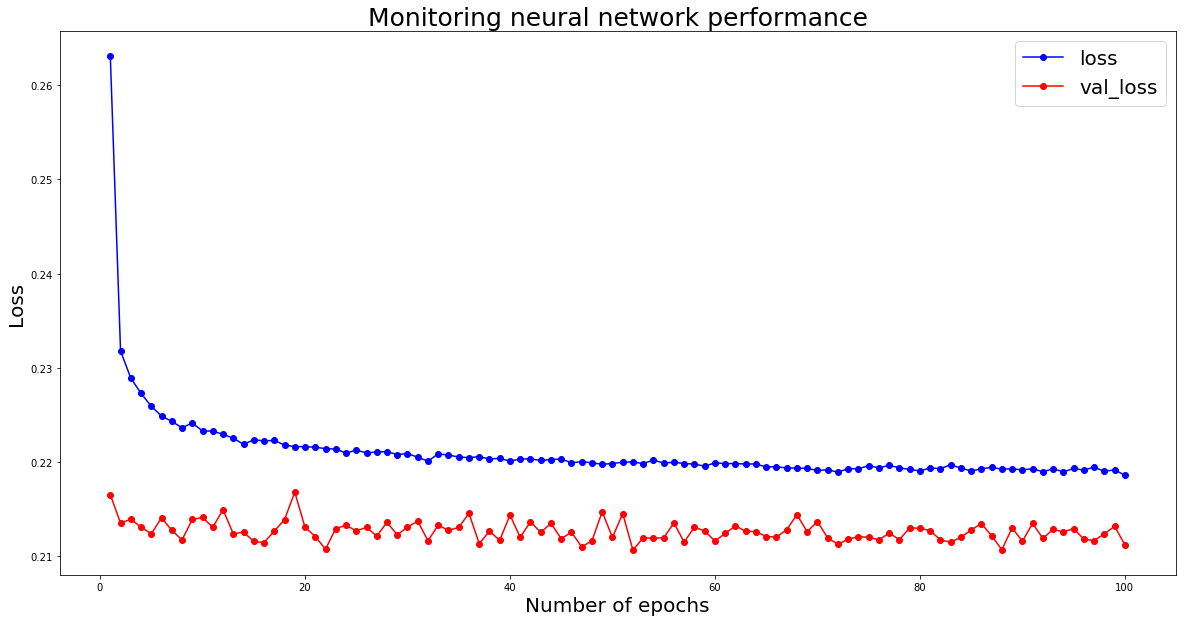

In [222]:
# Increase Dropout rate
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

In [ ]:
# Increase complexity
from keras import models, metrics, layers
import matplotlib.pyplot as plt
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_balanced_trans_100.shape[1],)))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(48,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(8,activation="relu"))
network1.add(layers.Dropout(0.1))
network1.add(layers.Dense(1,activation= "sigmoid"))
network1.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])
history_net1 = network1.fit(X_train_balanced_trans_100.tocsr(),y_train_balanced,  
                             epochs=100,batch_size=200,validation_split= 0.5)


epochs = list(range(1,len(history_net1.history["loss"]) +1))
print("Min loss: " + str(min(history_net1.history["loss"])) + " at epoch " + str(history_net1.history["loss"].index(min(history_net1.history["loss"])) + 1))
print("Min val loss: " + str(min(history_net1.history["val_loss"]))+ " at epoch " + str(history_net1.history["val_loss"].index(min(history_net1.history["val_loss"])) + 1))
plt.plot(epochs,history_net1.history["loss"],marker = "o", color = "b", label = "loss")
plt.plot(epochs,history_net1.history["val_loss"],marker = "o", color = "r", label = "val_loss")
plt.legend(fontsize = 20)
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Monitoring neural network performance",fontsize=25)
plt.show()

Train on 417611 samples, validate on 417611 samples
Epoch 1/100
417611/417611 [==============================] - 30s 72us/step - loss: 0.2612 - acc: 0.9002 - val_loss: 0.2161 - val_acc: 0.9190
Epoch 2/100
417611/417611 [==============================] - 23s 55us/step - loss: 0.2304 - acc: 0.9124 - val_loss: 0.2144 - val_acc: 0.9190
Epoch 3/100
417611/417611 [==============================] - 26s 63us/step - loss: 0.2279 - acc: 0.9131 - val_loss: 0.2138 - val_acc: 0.9190
Epoch 4/100
417611/417611 [==============================] - 22s 53us/step - loss: 0.2269 - acc: 0.9131 - val_loss: 0.2185 - val_acc: 0.9189
Epoch 5/100
417611/417611 [==============================] - 24s 57us/step - loss: 0.2259 - acc: 0.9135 - val_loss: 0.2126 - val_acc: 0.9199
Epoch 6/100
417611/417611 [==============================] - 24s 58us/step - loss: 0.2248 - acc: 0.9135 - val_loss: 0.2133 - val_acc: 0.9194
Epoch 7/100
417611/417611 [==============================] - 25s 60us/step - loss: 0.2245 - acc: 0.913

417611/417611 [==============================] - 22s 53us/step - loss: 0.2197 - acc: 0.9149 - val_loss: 0.2128 - val_acc: 0.9203
Epoch 59/100
417611/417611 [==============================] - 21s 51us/step - loss: 0.2196 - acc: 0.9145 - val_loss: 0.2125 - val_acc: 0.9202
Epoch 60/100
417611/417611 [==============================] - 22s 52us/step - loss: 0.2198 - acc: 0.9147 - val_loss: 0.2133 - val_acc: 0.9199
Epoch 61/100
417611/417611 [==============================] - 22s 53us/step - loss: 0.2195 - acc: 0.9148 - val_loss: 0.2136 - val_acc: 0.9204
Epoch 62/100
417611/417611 [==============================] - 22s 52us/step - loss: 0.2195 - acc: 0.9148 - val_loss: 0.2150 - val_acc: 0.9206
Epoch 63/100
417611/417611 [==============================] - 22s 52us/step - loss: 0.2196 - acc: 0.9147 - val_loss: 0.2131 - val_acc: 0.9198
Epoch 64/100
417611/417611 [==============================] - 22s 52us/step - loss: 0.2198 - acc: 0.9147 - val_loss: 0.2161 - val_acc: 0.9199
Epoch 65/100
417611